# Exercise 3 - Convolutional Neural Networks

## Group *ID* : $2207$

### Members

- Pietro Cappelli
    - e-mail: pietro.cappelli@studenti.unipd.it
    - ID: 2058332
- Alberto Coppi
    - e-mail: alberto.coppi@studenti.unipd.it
    - ID: 2053063
- Giacomo Franceschetto
    - e-mail: giacomo.franceschetto@studenti.unipd.it
    - ID: 2053348
- Nicolò Lai
    - e-mail: nicolo.lai@studenti.unipd.it
    - ID: 2064377 
### Author contribution statement

Each and every member of the group equally worked on the drafting of this notebook. 

## Import libraries and custom modules

In [ ]:
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns


import keras
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, GlobalMaxPooling1D
from keras        import regularizers, initializers
from scipy.signal import detrend

import _2207_plot_utils    as plot_utils
import _2207_generate_data as generate_data

In [ ]:
# reproducibility
np.random.seed(12345)
tf.random.set_seed(12345)

## Functions

In [ ]:
def standardize_sample(x):
    """rescale data sample-wise: for each sample subtract the mean and divide by std"""

    xm = x.mean(axis=1)
    for i in range(N):
        x[i] = x[i]-xm[i]
    vm = np.std(x, axis=1)
    x = x/vm[:, np.newaxis]
    
    return x

def standardize_all(x):
    """rescale data semi-sample-wise: subtract the mean sample-wise then divide by the total std"""

    xm = x.mean(axis=1)
    for i in range(N):
        x[i] = x[i]-xm[i]
    vm = np.std(x)
    x = x/vm

    return x


def keras_reshape(x):
    """reshape data to fit keras shape requirements"""
    
    return x.reshape(x.shape[0], x.shape[1], 1)


## Generate Data

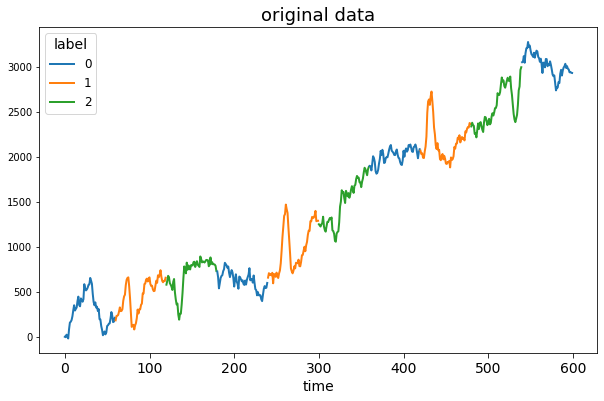

number of data :  10000


In [ ]:
# time series data parameters
L       = 60
Z       = 12
A       = 500
DX      = 50
bias    = 5
N       = 10000
n_class = 3  

# create dataset saved as DATA/<fname>
fname = generate_data.generate_data(
    N    = N,
    L    = L,
    Z    = Z,
    A    = A,
    DX   = DX,
    bias = bias,
    verbose = False,
)

# time series data filenames
fnamex='DATA/x_'+fname
fnamey='DATA/y_'+fname

# load data
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
# load categories
c = np.loadtxt(fnamey, dtype=int)
# build time grid
t_grid = np.arange(0, L*N).reshape(N, L)

# format labels from categories
y = np.zeros((N, n_class))
for i in range(N):
    y[i][c[i]] = 1

fig = plt.figure(figsize=(10,6))
ax = plot_utils.plot_data(x, t_grid, fig, n_samples=10, title="original data", legend=True)
plt.show()

print("number of data : ", N)

### Rescale data

Using ```scipy.signal.detrend``` we delete the linear increasing trend of our time series. Next we standardize our data by subtracting each sample by its mean and dividing by the global standard deviation. 

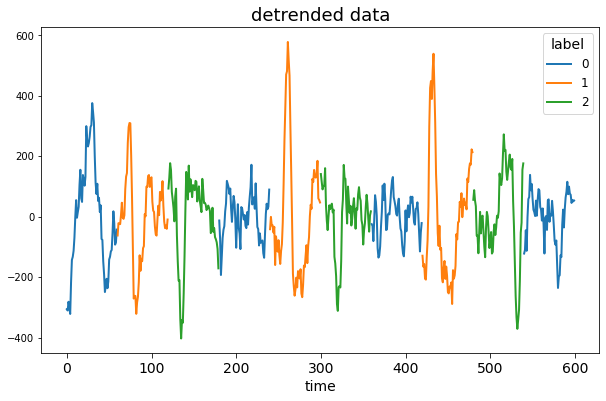

In [ ]:
# remove linear trend from data
x_detrend = detrend(x)

fig = plt.figure(figsize=(10,6))
ax = plot_utils.plot_data(x_detrend, t_grid, fig, n_samples=10, title="detrended data", legend=True)
plt.show()

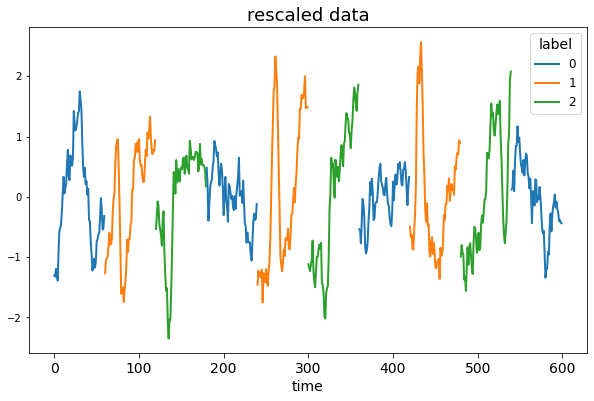

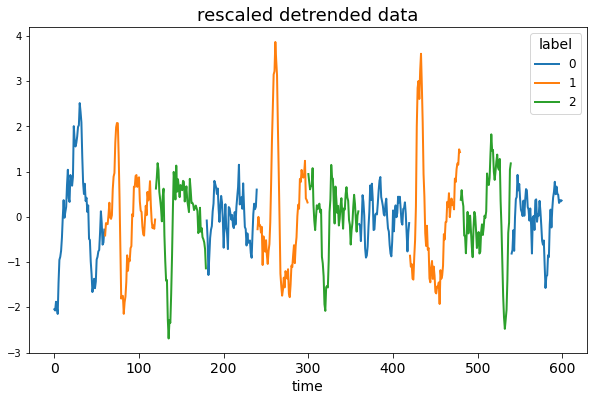

In [ ]:
# standardize original data
x_scaled = standardize_all(x)

fig = plt.figure(figsize=(10,6))
ax = plot_utils.plot_data(x_scaled, t_grid, fig, n_samples=10, title="rescaled data", legend=True)
plt.show()

# standardize detrended data
x_scaled = standardize_all(x_detrend)

fig = plt.figure(figsize=(10,6))
ax = plot_utils.plot_data(x_scaled, t_grid, fig, n_samples=10, title="rescaled detrended data", legend=True)
plt.show()

x = np.copy(x_scaled)

We see a reasonable improvement in data clarity when we delete the linear trend within the time series. We will use detrended data from now on.

### Training, validation and test sets

In [ ]:
train_test_frac  = 0.7
valid_train_frac = 0.3

N_train = int(N*train_test_frac*(1-valid_train_frac))
N_valid = int(N*train_test_frac*valid_train_frac)
N_test  = int(N*(1-train_test_frac))

train_idx = N_train
valid_idx = N_train+N_valid
test_idx  = N_train+N_test

x_train    = x[0:train_idx]
y_train    = y[0:train_idx]
x_val      = x[train_idx:valid_idx]
y_val      = y[train_idx:valid_idx]
x_test     = x[valid_idx:test_idx]
y_test     = y[valid_idx:test_idx]

print('N_train =',N_train,'  N_val =',N_valid,'  N_test =',N_test,'  L =',L,'  n_class =',n_class)

#x_train=x_train.astype("float32")
#y_train=y_train.astype("float32")
#x_val=x_val.astype("float32")
#y_val=y_val.astype("float32")

x_train = keras_reshape(x_train)
x_val   = keras_reshape(x_val)

input_shape = (L, 1)

N_train = 4900   N_val = 2100   N_test = 3000   L = 60   n_class = 3


## CNN - L2 regularization

In [ ]:
reg = regularizers.l2(0.02)
ini = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

NF    = 5 # number of filters

model = Sequential(name="carlo")

model.add(
    Conv1D(
        filters            = NF, 
        kernel_size        = 11, 
        kernel_initializer = ini,
        kernel_regularizer = reg,
        activation         = 'relu',
        input_shape        = input_shape
    )
)
model.add(AveragePooling1D(5)) # average of 5 values
model.add(Conv1D(filters=5, kernel_size=7, activation='relu'))
model.add(Flatten())
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(n_class, activation='softmax'))

print(model.summary())

opt = tf.keras.optimizers='Adam'

# compile
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

Model: "carlo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 5)             60        
                                                                 
 average_pooling1d (AverageP  (None, 10, 5)            0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 5)              180       
                                                                 
 flatten (Flatten)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 12)                252       
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                                             

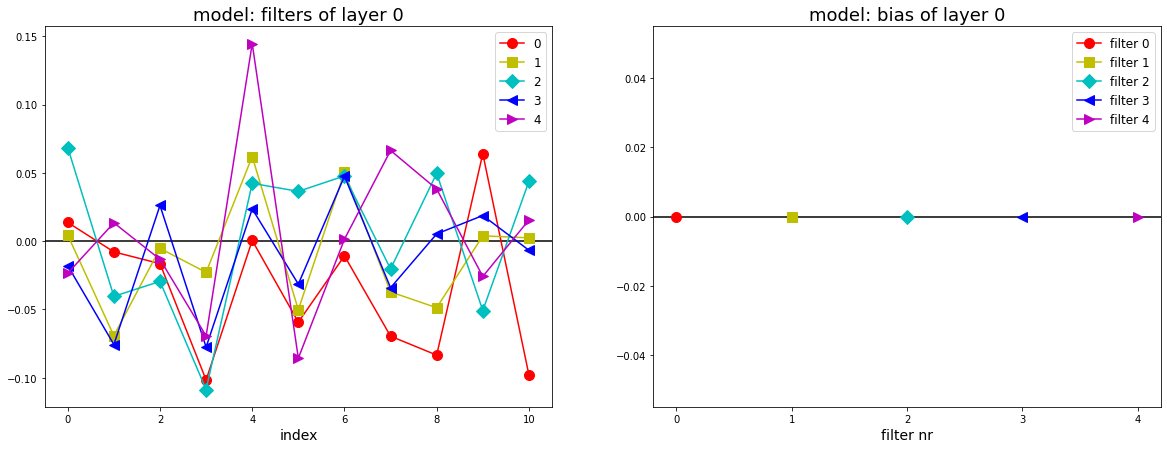

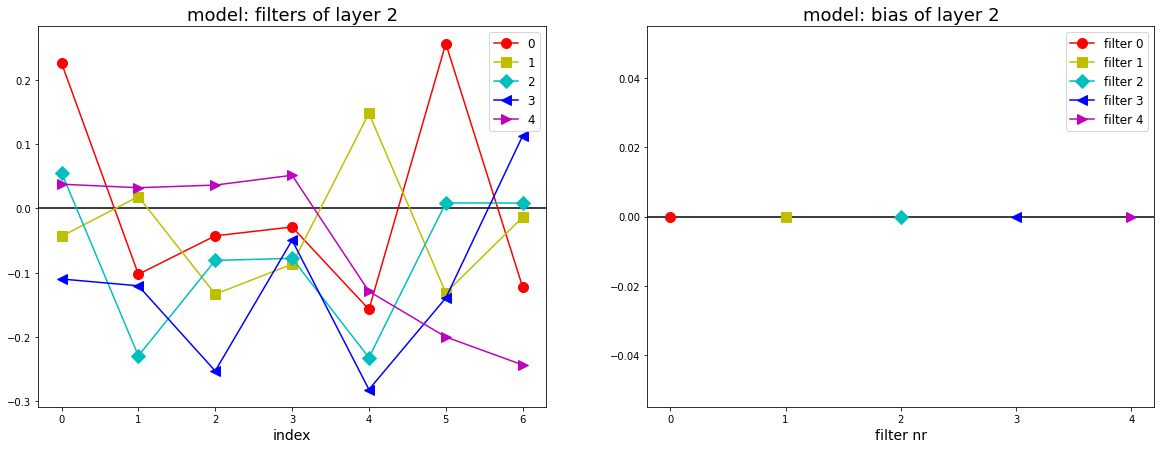

In [ ]:
# plot convolutional layers weights
    
fig = plt.figure(figsize=(20, 7))
ax = plot_utils.plot_weights(model=model,layer=0, fig=fig)
plt.show()

fig = plt.figure(figsize=(20, 7))
ax = plot_utils.plot_weights(model=model,layer=2, fig=fig)
plt.show()

### Training

In [ ]:
BATCH_SIZE = 250
EPOCHS     = 100

fit = model.fit(
    x_train, 
    y_train, 
    batch_size      = BATCH_SIZE,
    epochs          = EPOCHS, 
    validation_data = (x_val, y_val),
    verbose         = 0, 
    shuffle         = True
)

### Plot accuracy, loss and weights

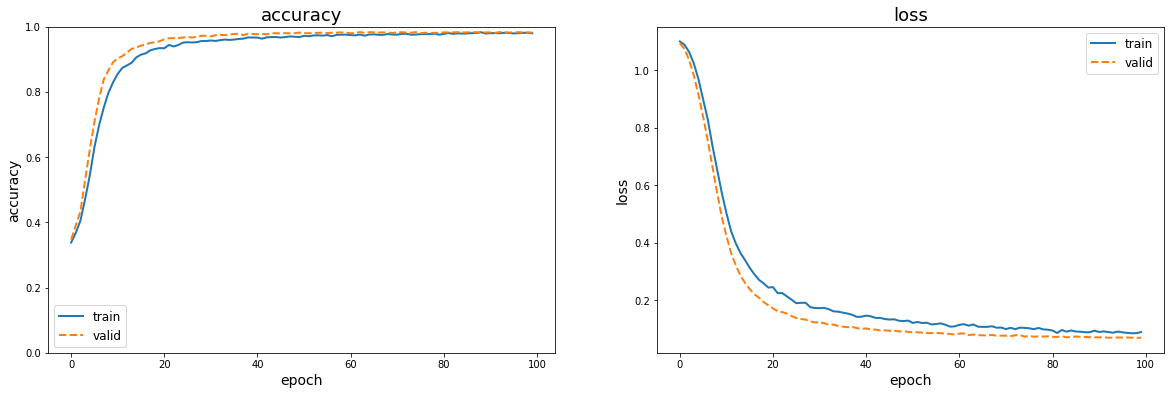

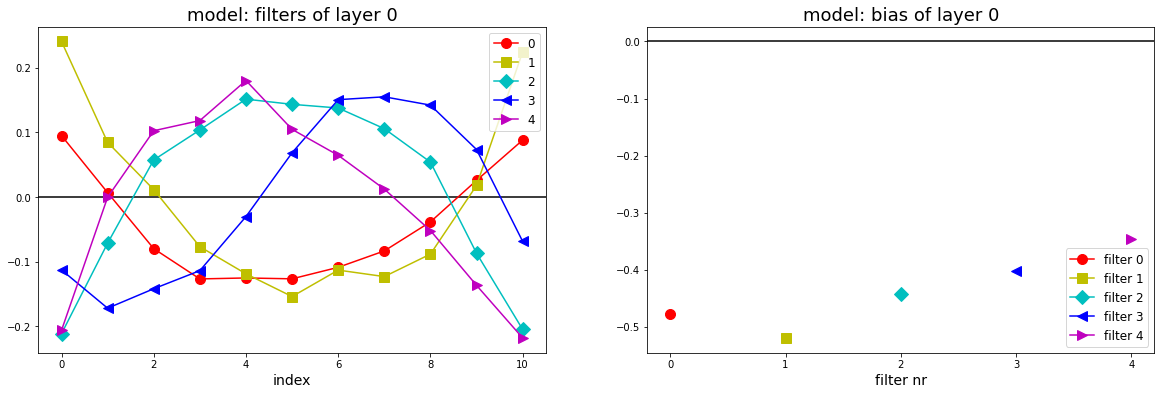

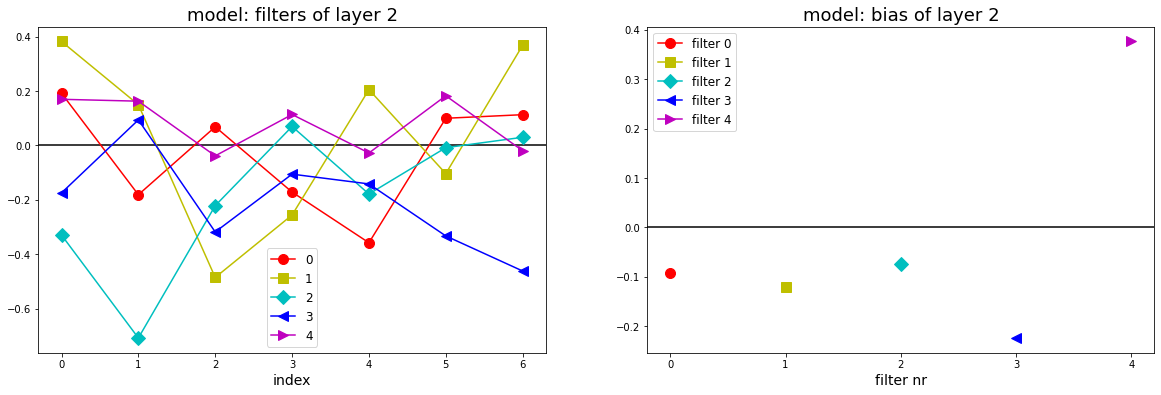

In [ ]:
fig = plt.figure(figsize=(20,6))
ax = plot_utils.plot_history(fit, fig)
plt.show()

fig1 = plt.figure(figsize=(20,6))
plot_utils.plot_weights(model, 0, fig=fig1)
fig2 = plt.figure(figsize=(20,6))
plot_utils.plot_weights(model, 2, fig=fig2)
plt.show()

### Plot confusion matrix

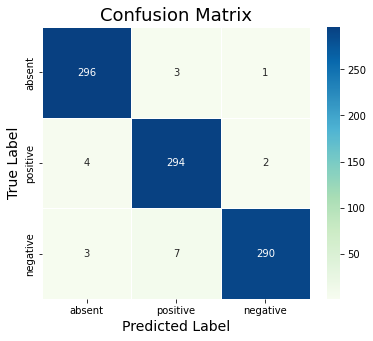

In [ ]:
y_pred_test = model.predict(x_test)
# Take the class with the highest probability from the val predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

fig = plt.figure(figsize=(6,5))
ax = plot_utils.show_confusion_matrix(true=max_y_test, pred=max_y_pred_test, fig=fig)
plt.show()

## CNN - L1 regularization

In [ ]:
reg = tf.keras.regularizers.l1(0.05)
ini = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

NF    = 5 # number of filters

model = Sequential(name="antonio")

model.add(
    Conv1D(
        filters            = NF, 
        kernel_size        = 11, 
        kernel_initializer = ini,
        kernel_regularizer = reg,
        activation         = 'relu',
        input_shape        = input_shape
    )
)
model.add(AveragePooling1D(5)) # average of 5 values
model.add(Conv1D(filters=5, kernel_size=7, activation='relu'))
model.add(Flatten())
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(n_class, activation='softmax'))

print(model.summary())

opt = tf.keras.optimizers='Adam'

# compile
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

BATCH_SIZE2 = 250
EPOCHS2 = 100

fit = model.fit(
    x_train, 
    y_train, 
    batch_size      = BATCH_SIZE2,
    epochs          = EPOCHS2, 
    validation_data = (x_val, y_val),
    verbose         = 0, 
    shuffle         = True
)


Model: "antonio"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_70 (Conv1D)          (None, 50, 5)             60        
                                                                 
 average_pooling1d_35 (Avera  (None, 10, 5)            0         
 gePooling1D)                                                    
                                                                 
 conv1d_71 (Conv1D)          (None, 4, 5)              180       
                                                                 
 flatten_35 (Flatten)        (None, 20)                0         
                                                                 
 dense_70 (Dense)            (None, 12)                252       
                                                                 
 dropout_35 (Dropout)        (None, 12)                0         
                                                           

### Plot accuracy, loss and weights

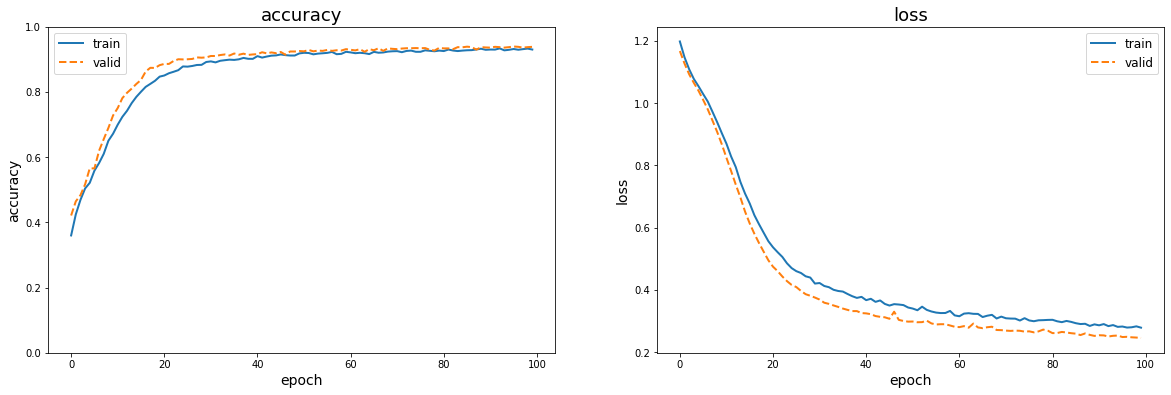

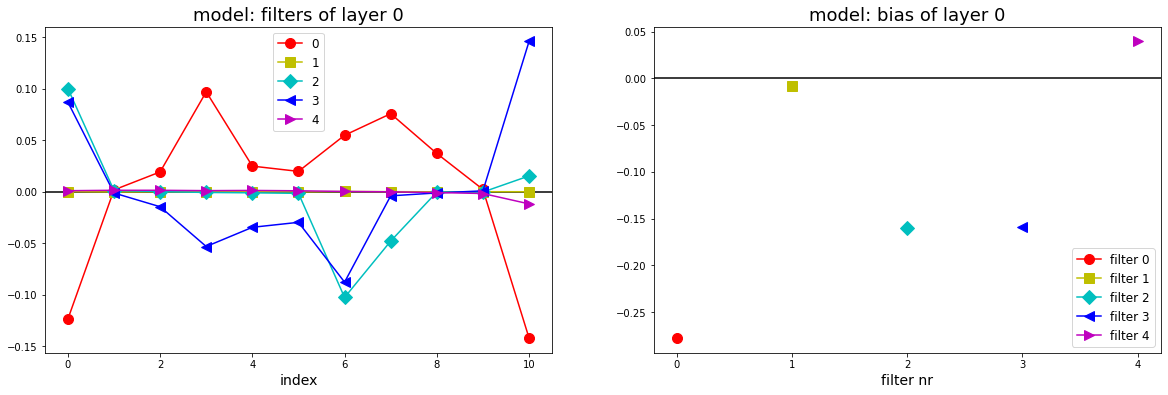

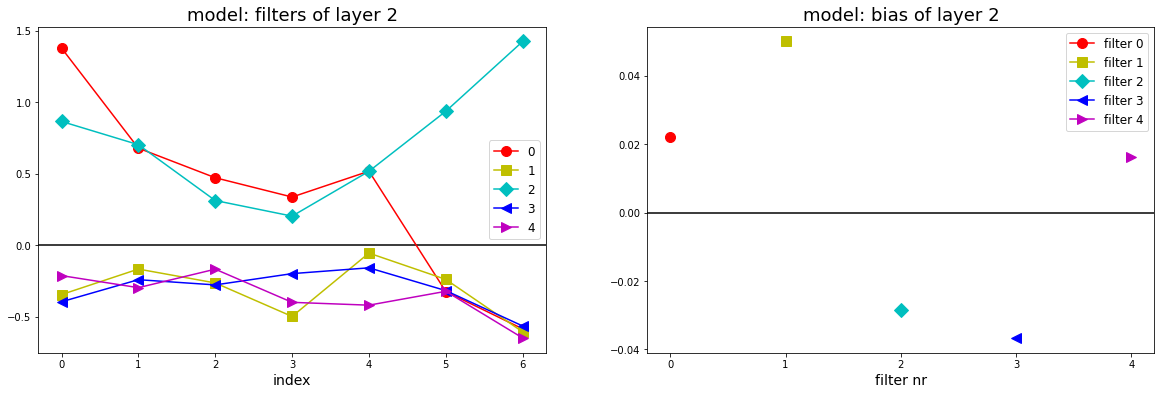

In [ ]:
fig = plt.figure(figsize=(20,6))
ax = plot_utils.plot_history(fit, fig)
plt.show()

fig1 = plt.figure(figsize=(20,6))
plot_utils.plot_weights(model, 0, fig=fig1)
fig2 = plt.figure(figsize=(20,6))
plot_utils.plot_weights(model, 2, fig=fig2)
plt.show()

### Plot confusion matrix

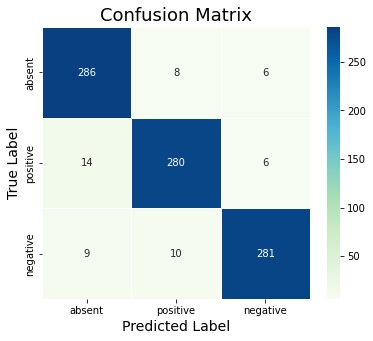

In [ ]:
y_pred_test2 = model.predict(x_test)
# Take the class with the highest probability from the val predictions
max_y_pred_test2 = np.argmax(y_pred_test2, axis=1)
max_y_test2 = np.argmax(y_test, axis=1)

fig = plt.figure(figsize=(6,5))
ax = plot_utils.show_confusion_matrix(true=max_y_test2, pred=max_y_pred_test2, fig=fig)
plt.show()

## Explore different signal-to-noise ratios

### Generate data with different signal amplitudes A

In [ ]:
A_list     = [0.1, 1, 10, 20, 50, 80, 150, 250, 400, 700, 1000]
file_names = [
    generate_data.generate_data(A=A, verbose=True) 
    for A in A_list
]

ts_L60_Z12_A0.1_DX50_bias5_N10000.dat
ts_L60_Z12_A1_DX50_bias5_N10000.dat
ts_L60_Z12_A10_DX50_bias5_N10000.dat
ts_L60_Z12_A20_DX50_bias5_N10000.dat
ts_L60_Z12_A50_DX50_bias5_N10000.dat
ts_L60_Z12_A80_DX50_bias5_N10000.dat
ts_L60_Z12_A150_DX50_bias5_N10000.dat
ts_L60_Z12_A250_DX50_bias5_N10000.dat
ts_L60_Z12_A400_DX50_bias5_N10000.dat
ts_L60_Z12_A700_DX50_bias5_N10000.dat
ts_L60_Z12_A1000_DX50_bias5_N10000.dat


### Training

In [ ]:
train_test_frac  = 0.7
valid_train_frac = 0.3

N_train = int(N*train_test_frac*(1-valid_train_frac))
N_valid = int(N*train_test_frac*valid_train_frac)
N_test  = int(N*(1-train_test_frac))

train_idx = N_train
valid_idx = N_train+N_valid
test_idx  = N_train+N_test

NF    = 5 # number of filters

reg = regularizers.l2(0.02)
ini = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

BATCH_SIZE = 250
EPOCHS     = 100

fits   = []
tests  = []
models = []
y_test_true = []
y_test_pred = []

for i, fname in enumerate(file_names):

    
    # load data
    x = np.loadtxt("DATA/x_"+fname, delimiter=" ",dtype=float)
    # load categories
    c = np.loadtxt("DATA/y_"+fname, dtype=int)
    # build time grid
    t_grid = np.arange(0, L*N).reshape(N, L)
    # format labels from categories
    y = np.zeros((N, n_class))
    for i in range(N):
        y[i][c[i]] = 1

    # data rescaling
    x_detrend = detrend(x)
    x = standardize_all(x_detrend)

    # split training validation test
    x_train    = x[0:train_idx]
    y_train    = y[0:train_idx]
    x_val      = x[train_idx:valid_idx]
    y_val      = y[train_idx:valid_idx]
    x_test     = x[valid_idx:test_idx]
    y_test     = y[valid_idx:test_idx]
    
    x_train = keras_reshape(x_train)
    x_val   = keras_reshape(x_val)

    input_shape = (L, 1)

    model = Sequential(name="carlo")
    model.add(
        Conv1D(
            filters            = NF, 
            kernel_size        = 11, 
            kernel_initializer = ini,
            kernel_regularizer = reg,
            activation         = 'relu',
            input_shape        = input_shape
        )
    )
    model.add(AveragePooling1D(5)) # average of 5 values
    model.add(Conv1D(filters=5, kernel_size=7, activation='relu'))
    model.add(Flatten())
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_class, activation='softmax'))

    opt = tf.keras.optimizers='Adam'

    # compile
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

    fit = model.fit(
        x_train, 
        y_train, 
        batch_size      = BATCH_SIZE,
        epochs          = EPOCHS, 
        validation_data = (x_val, y_val),
        verbose         = 0, 
        shuffle         = True
    )

    test = model.evaluate(
        x_test, y_test,
        batch_size      = BATCH_SIZE,
        verbose         = 0,
    )

    fits.append(fit)
    tests.append(test)
    models.append(model)

    y_pred_test = model.predict(x_test)
    max_y_pred_test = np.argmax(y_pred_test, axis=1)
    max_y_test = np.argmax(y_test, axis=1)

    y_test_true.append(max_y_test)
    y_test_pred.append(max_y_pred_test)


### Plot loss, accuracy, confusion matrix and weights

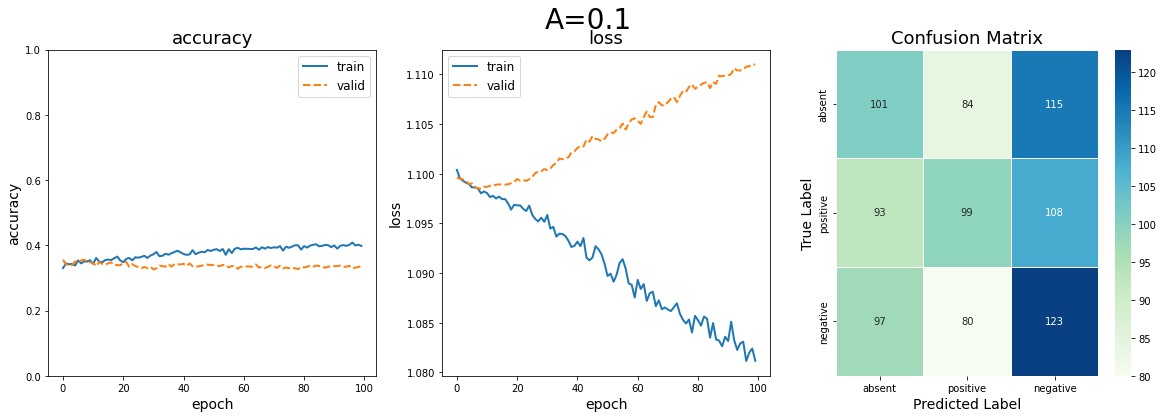

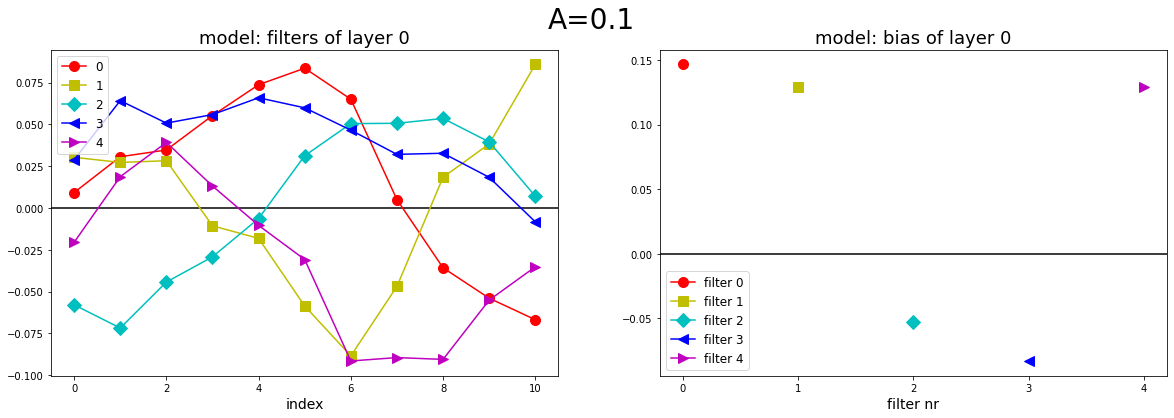

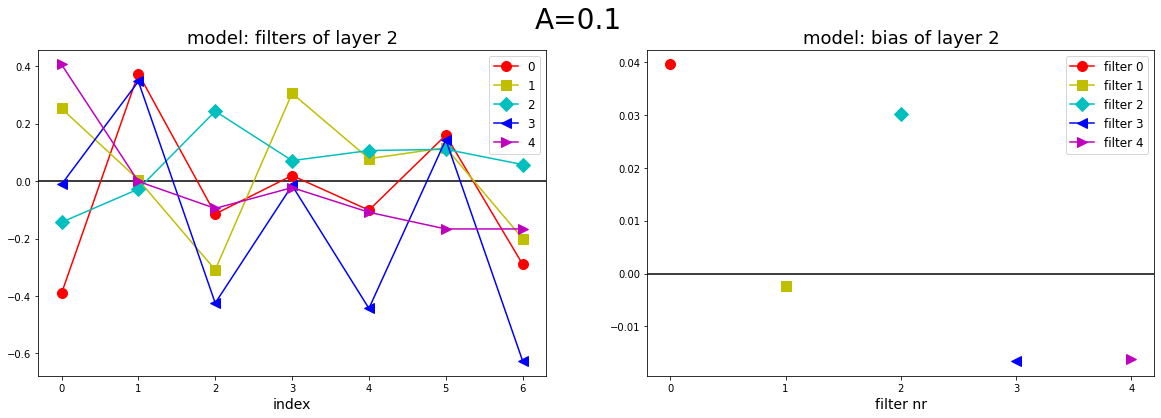

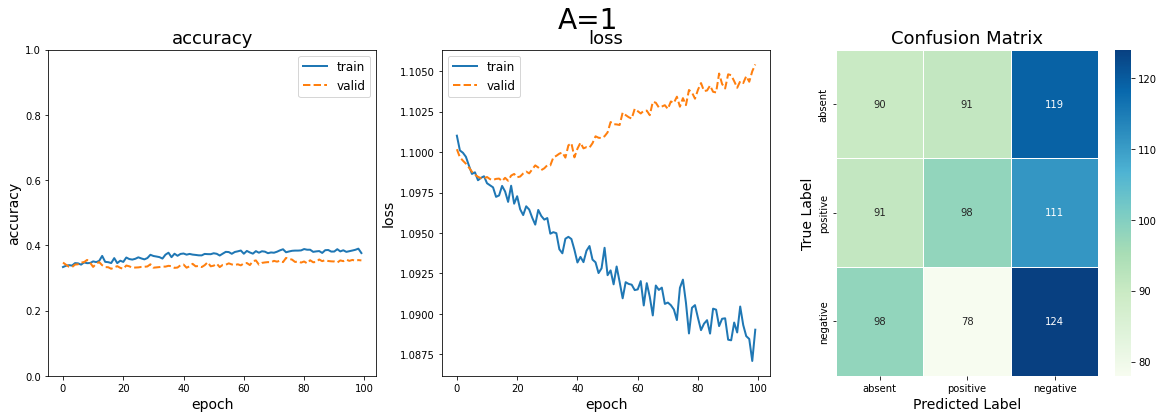

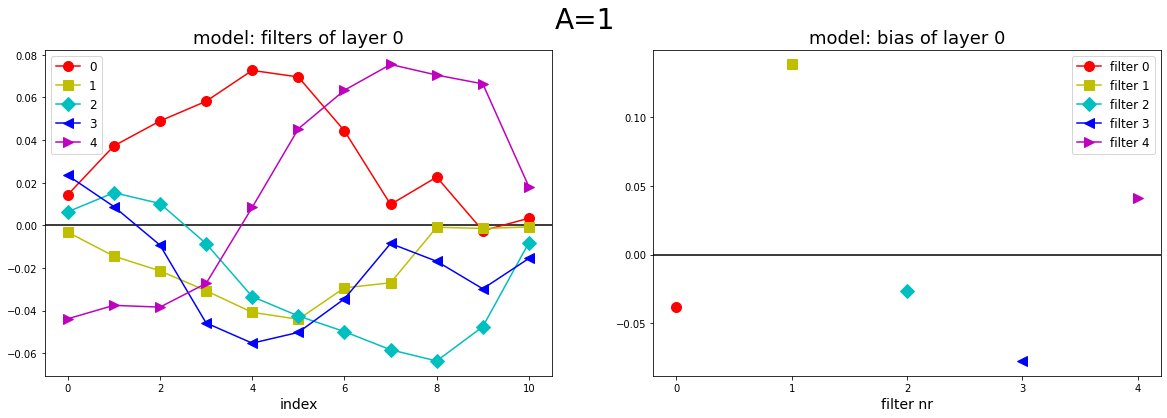

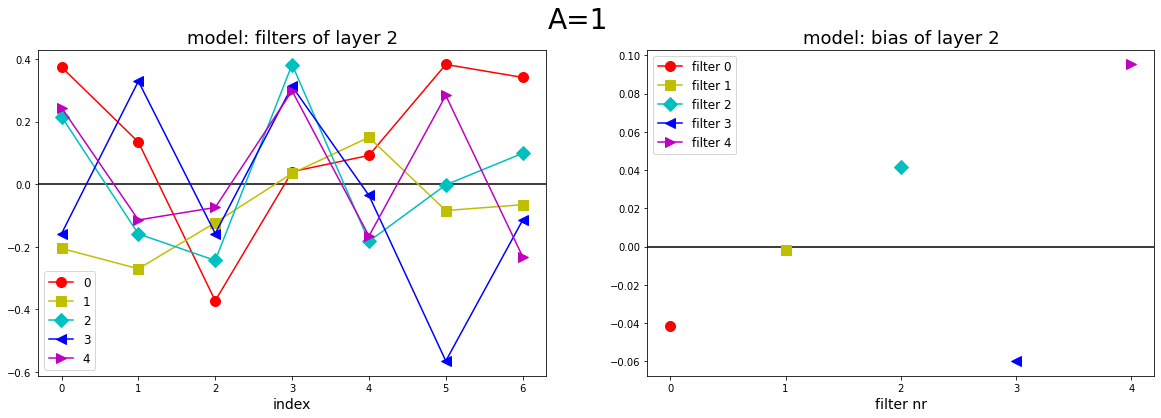

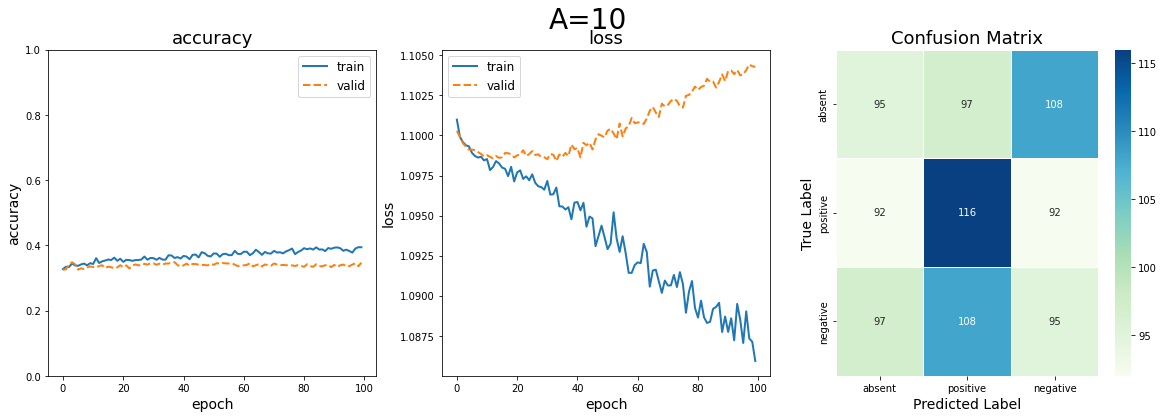

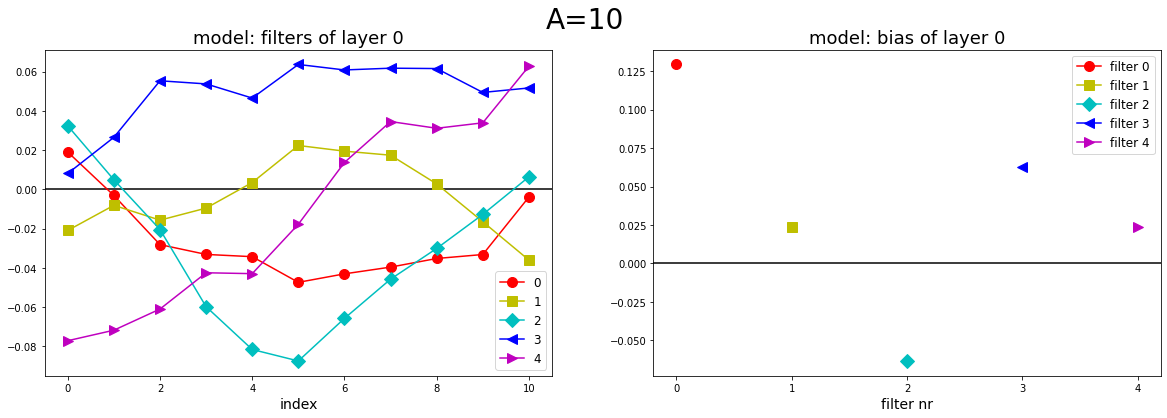

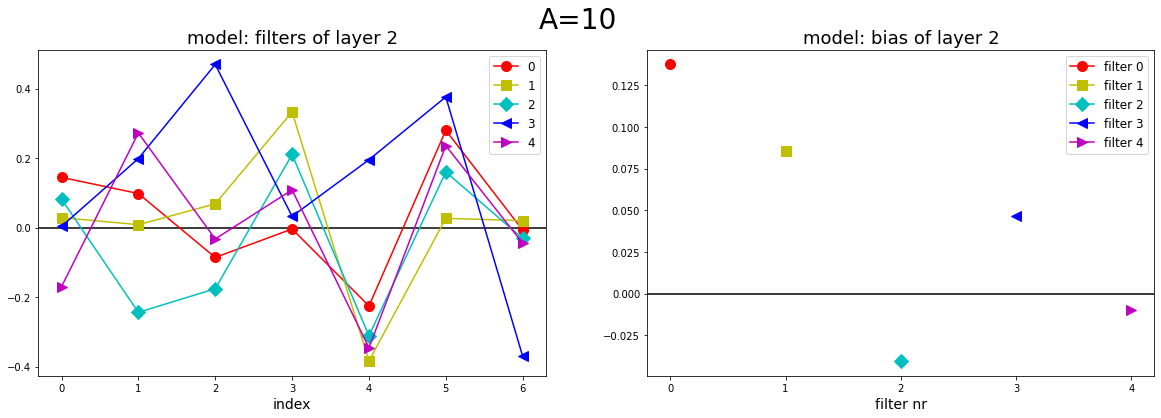

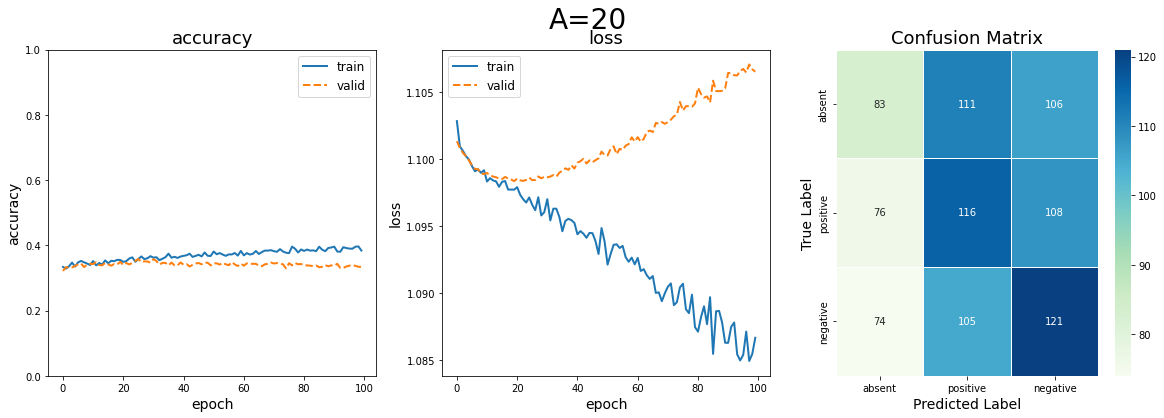

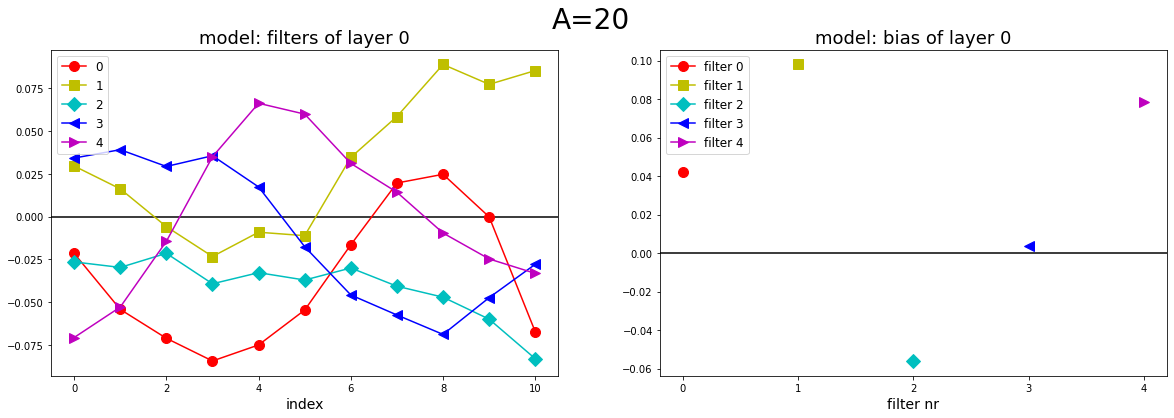

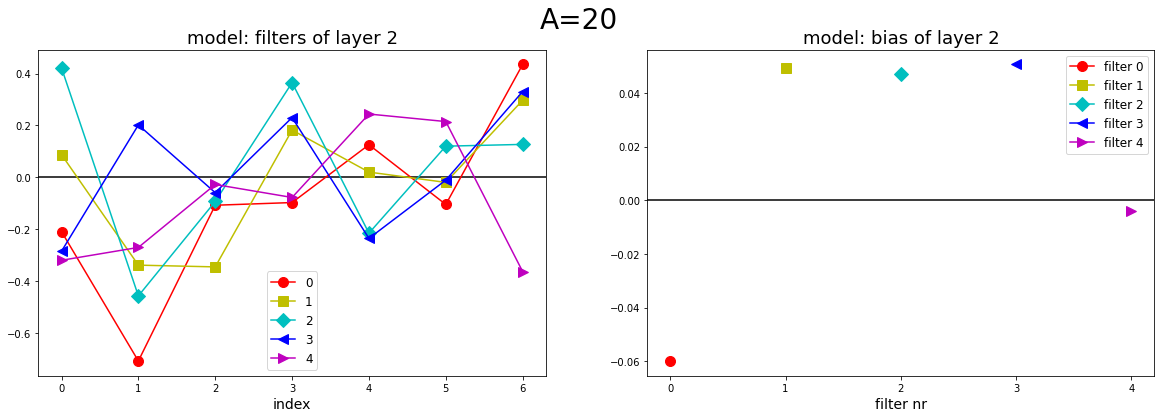

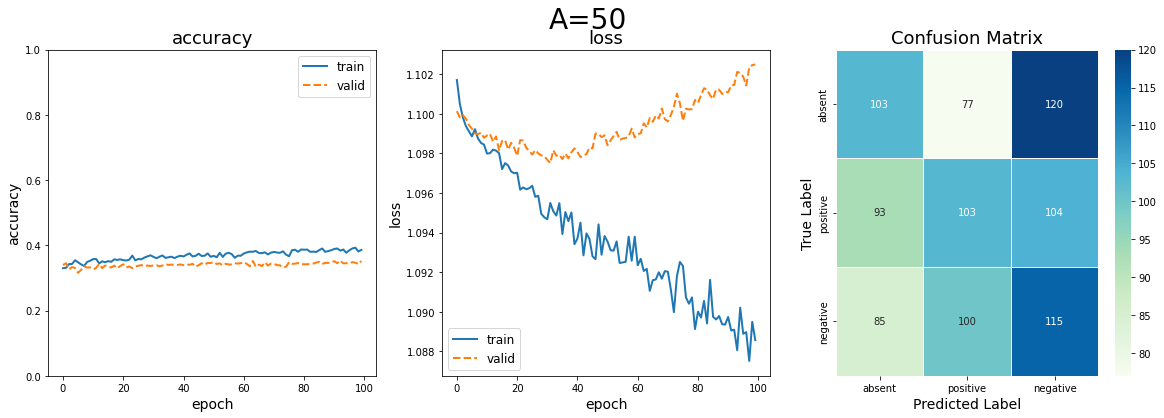

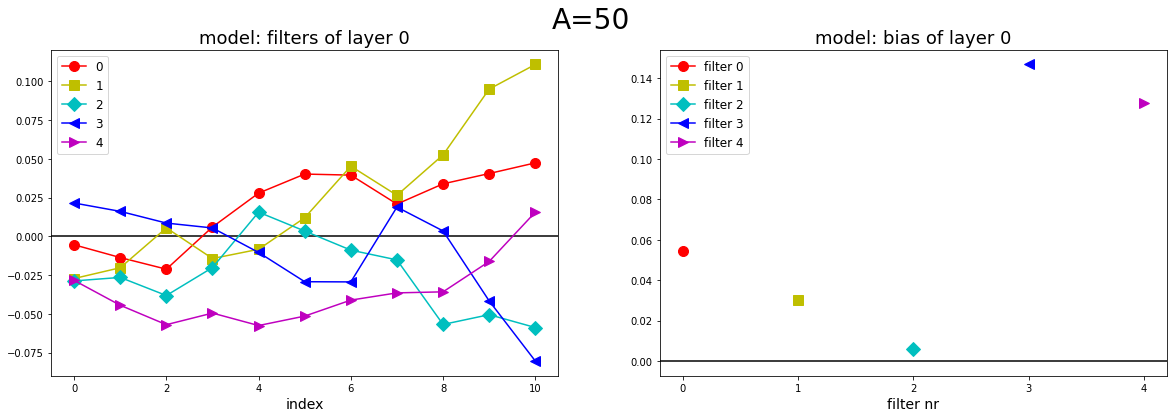

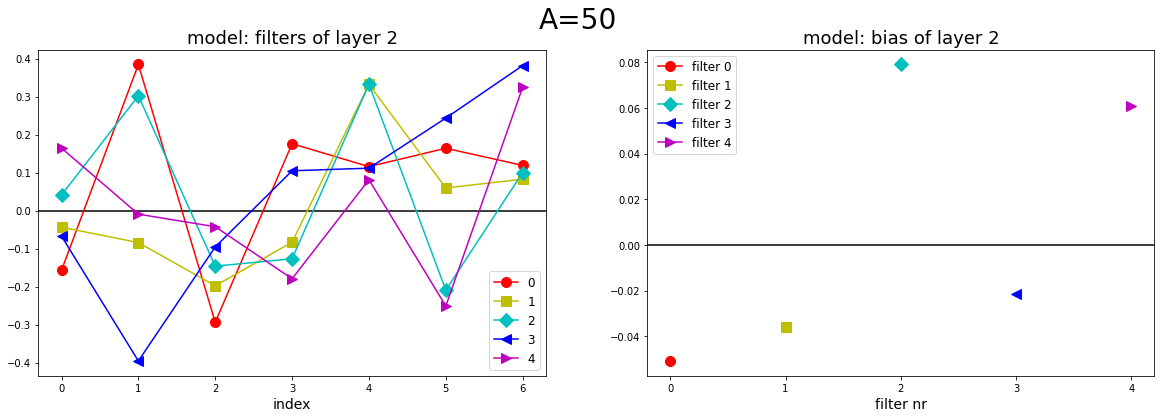

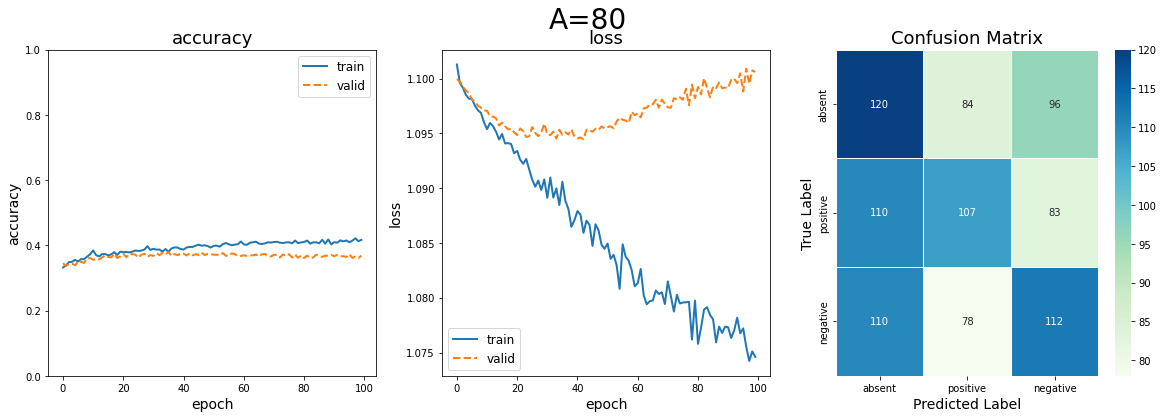

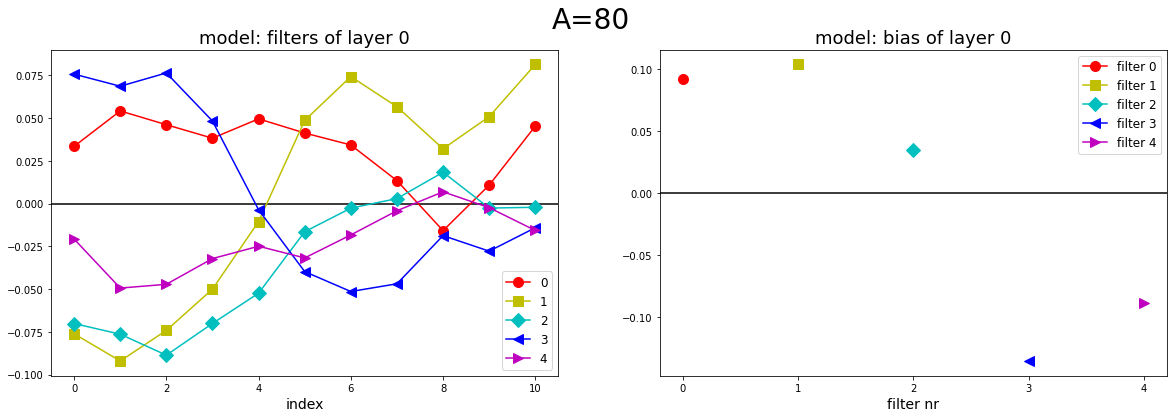

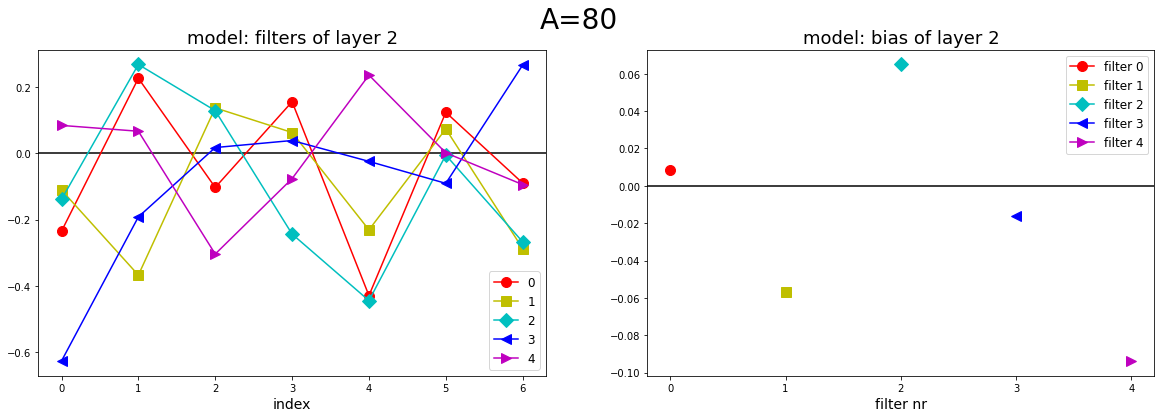

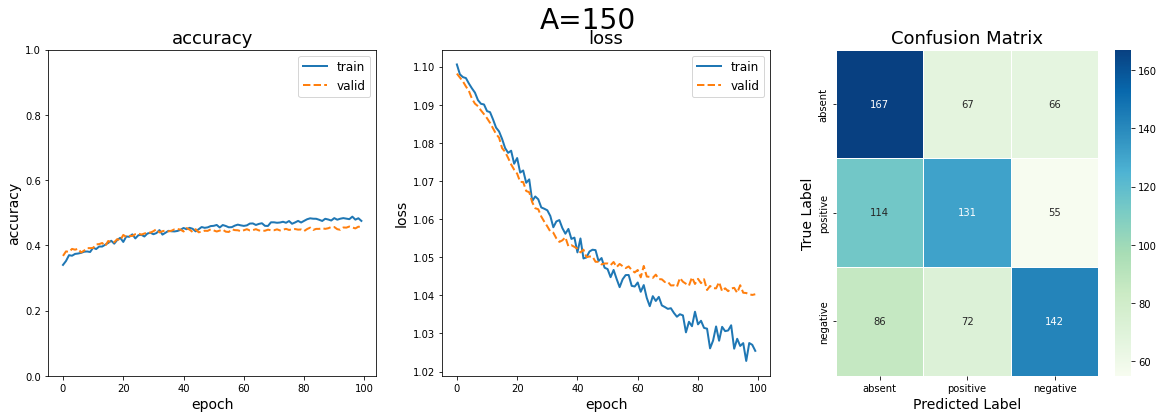

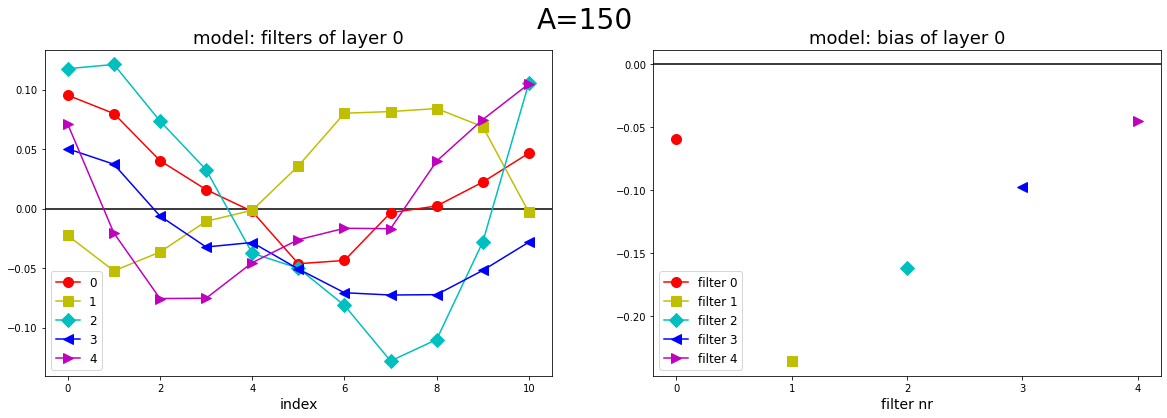

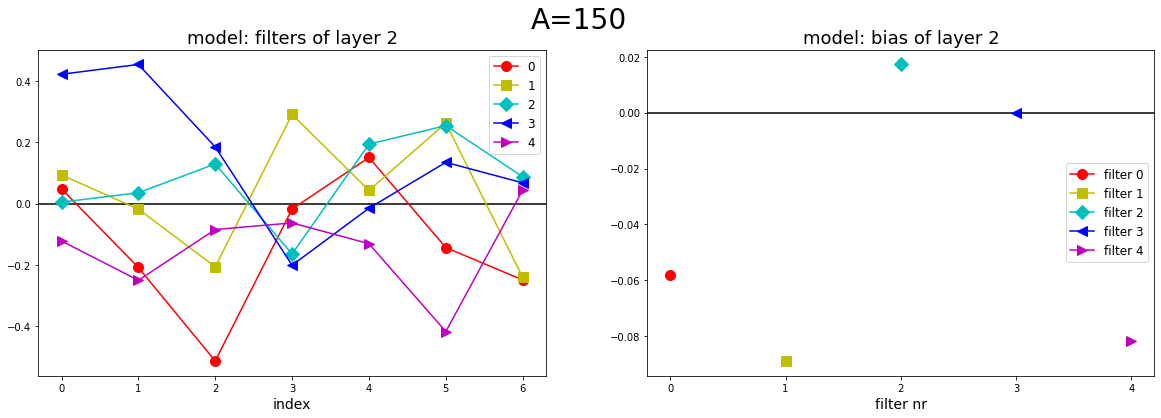

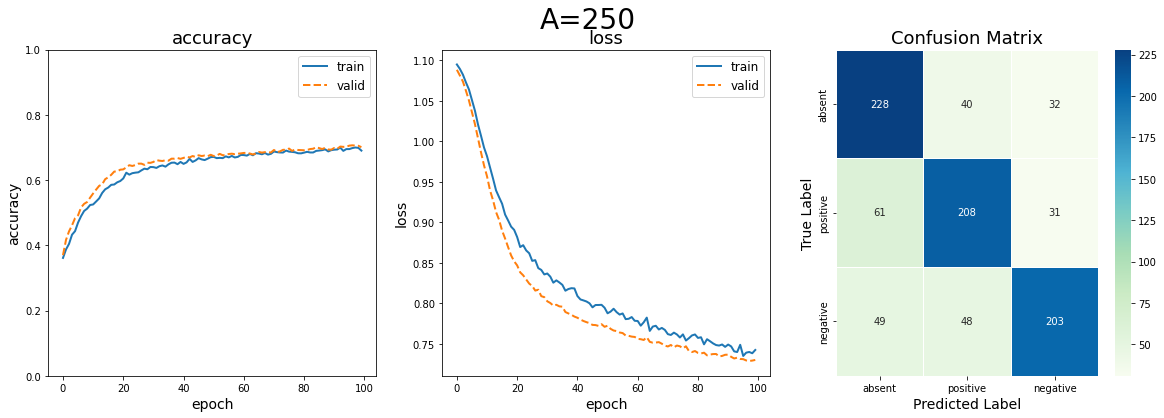

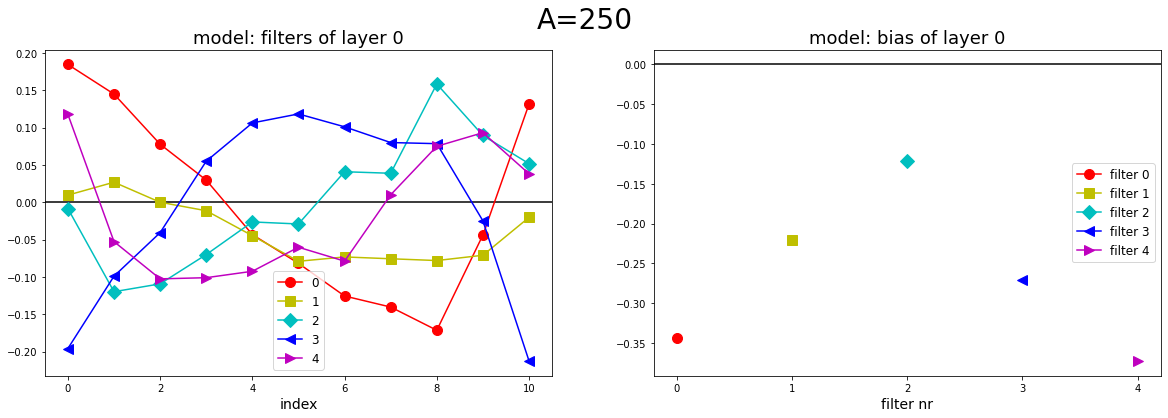

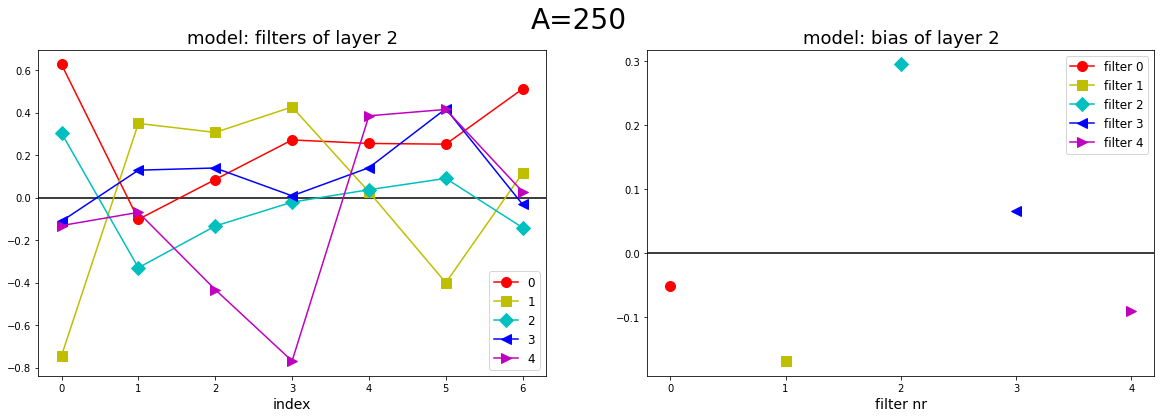

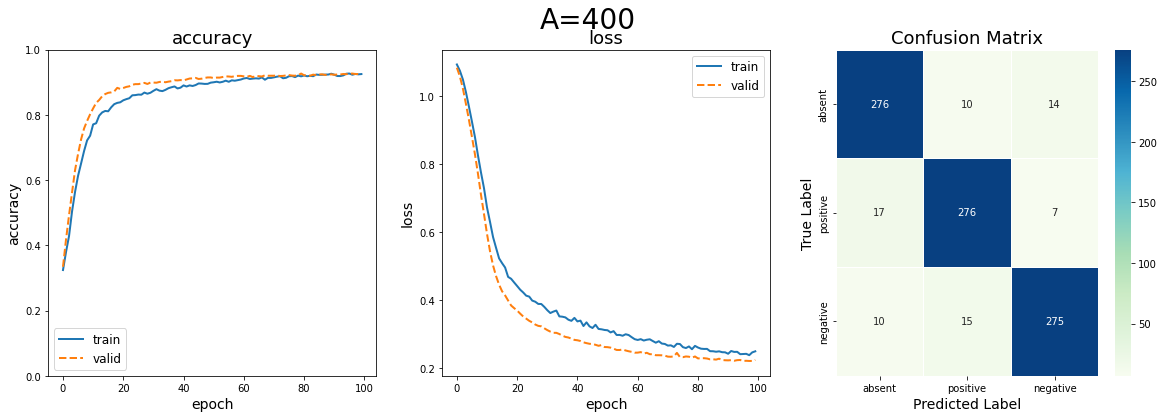

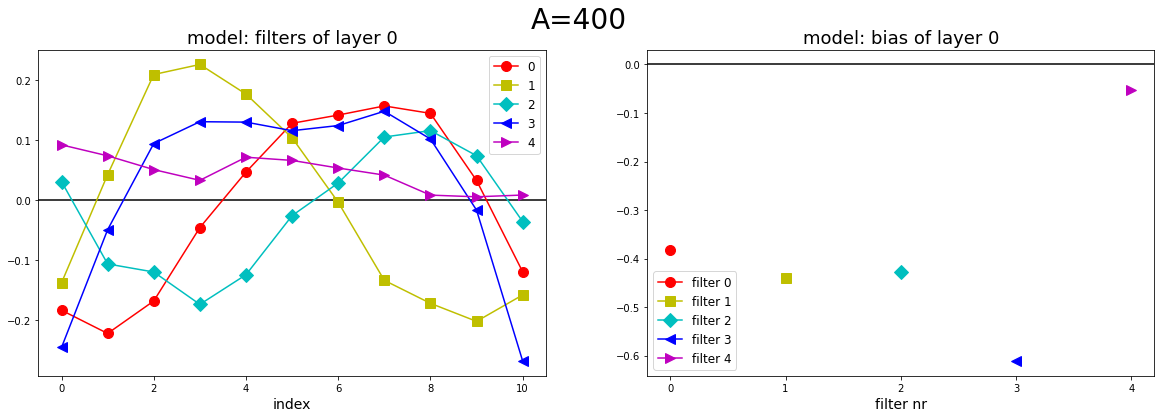

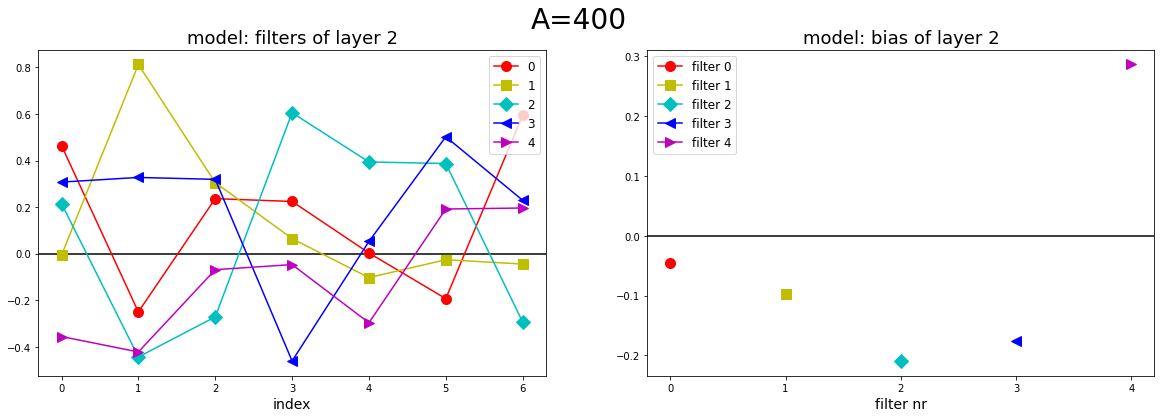

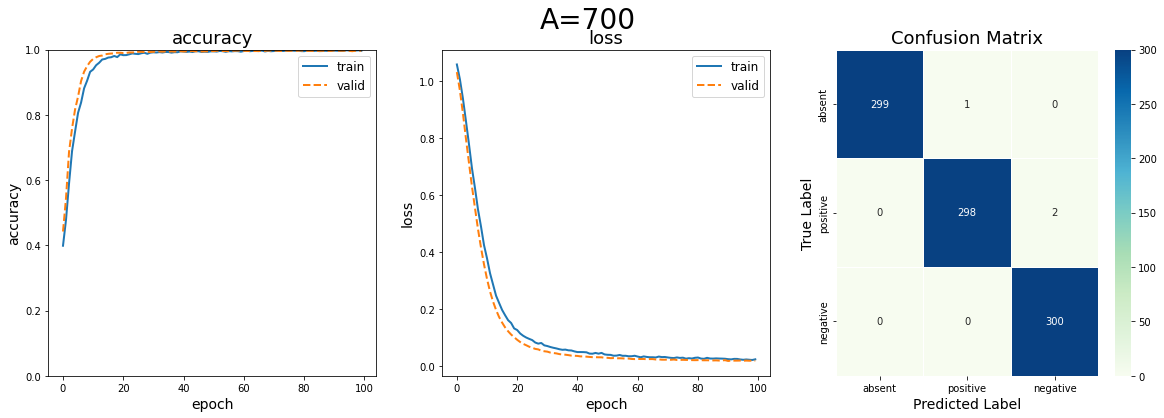

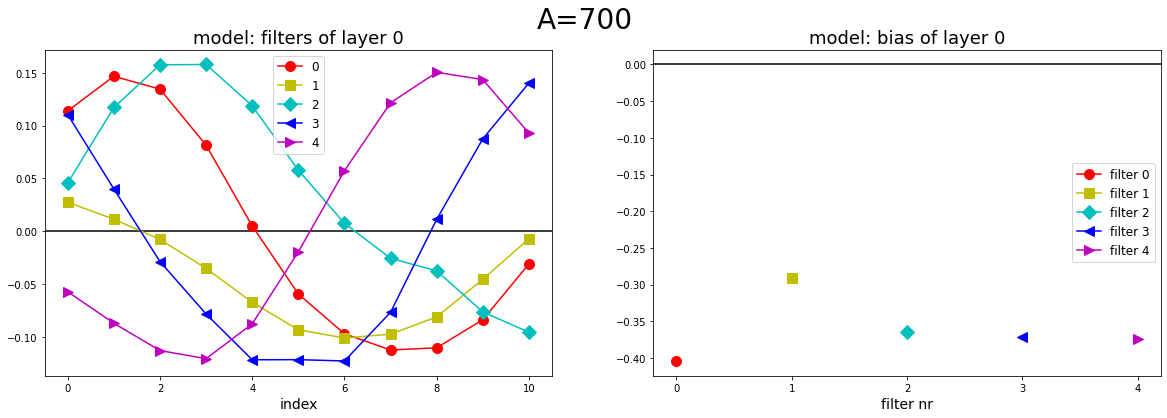

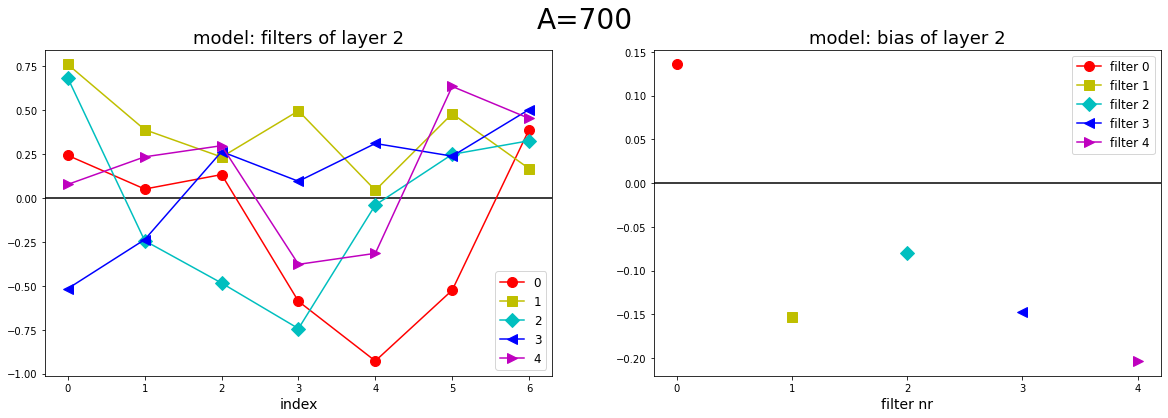

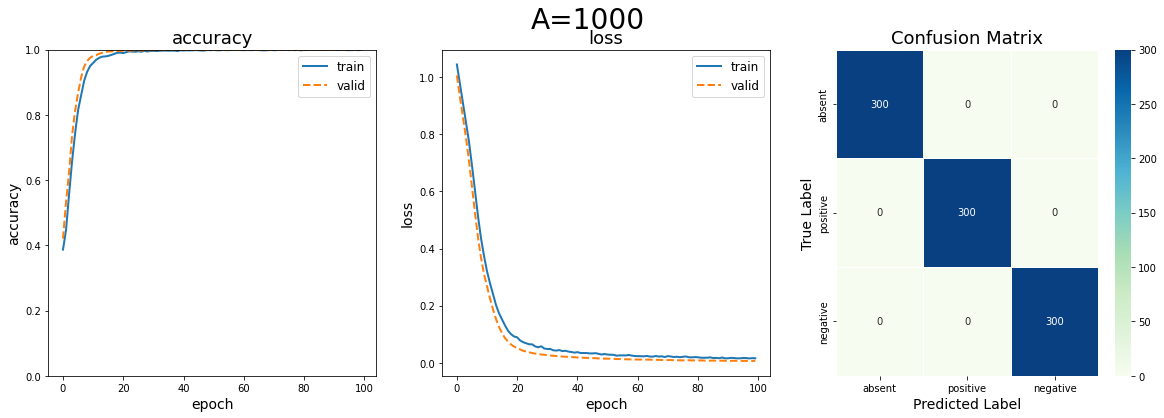

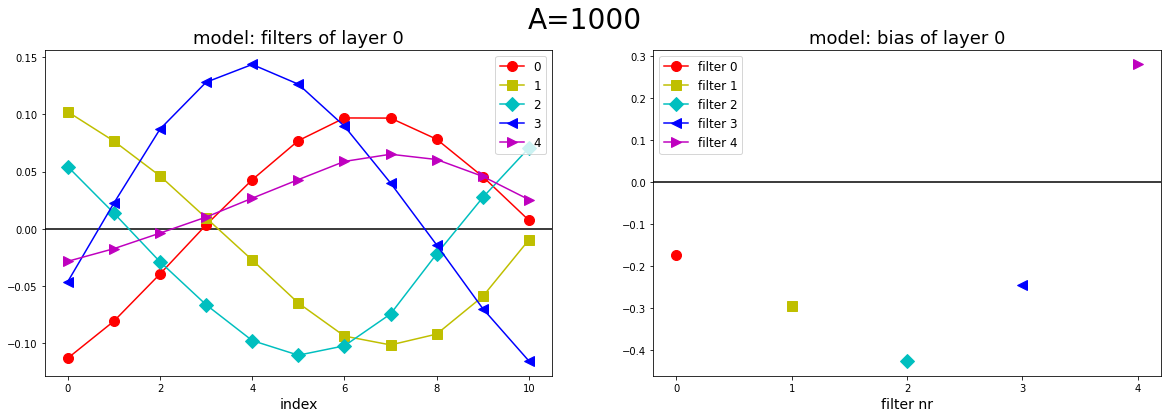

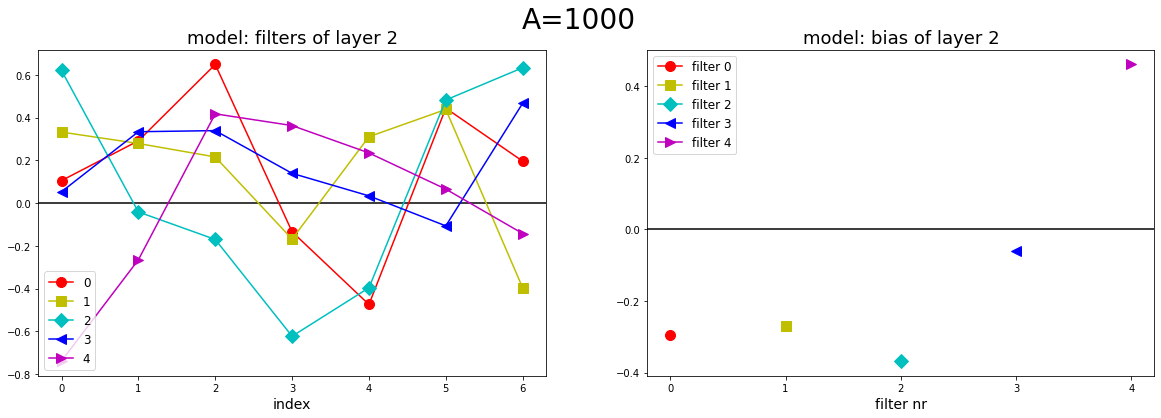

In [ ]:
for i, (fit, model) in enumerate(zip(fits, models)):

    fig = plt.figure(figsize=(20,6))
    fig.suptitle(f"A={A_list[i]}", fontsize=28)
    ax  = plot_utils.plot_history(fit, fig, ncols=3)
    ax  = plot_utils.show_confusion_matrix(true=y_test_true[i], pred=y_test_pred[i], fig=fig, subplot_id=133)
    plt.show()

    fig = plt.figure(figsize=(20,6))
    fig.suptitle(f"A={A_list[i]}", fontsize=28)
    ax  = plot_utils.plot_weights(model, 0, fig=fig)
    plt.show()
    fig = plt.figure(figsize=(20,6))
    fig.suptitle(f"A={A_list[i]}", fontsize=28)
    ax  = plot_utils.plot_weights(model, 2, fig=fig)
    plt.show()

### Summary loss and accuracy trend over A

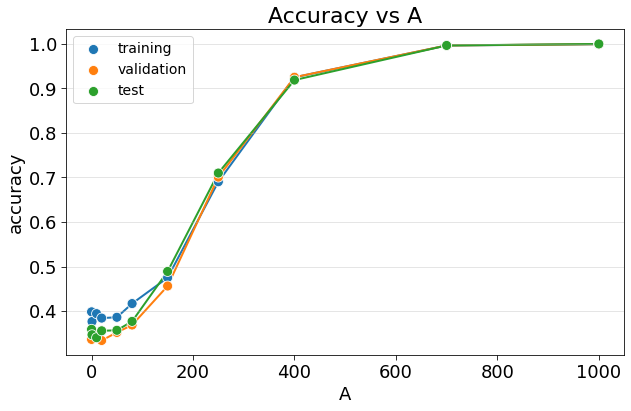

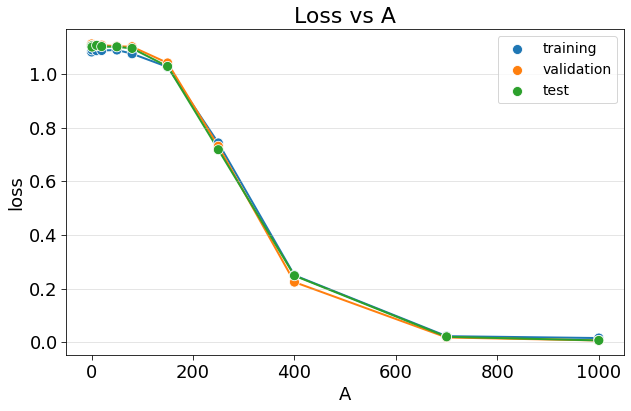

In [ ]:
final_train_acc = [fit.history["accuracy"][-1]     for fit in fits]
final_valid_acc = [fit.history["val_accuracy"][-1] for fit in fits]
test_acc        = [test[1]                 for test in tests]

final_train_loss = [fit.history["loss"][-1]     for fit in fits]
final_valid_loss = [fit.history["val_loss"][-1] for fit in fits]
test_loss        = [test[0]             for test in tests]

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax = plot_utils.scatter_results(
    parameter=A_list,
    result=final_train_acc,
    fig=fig,
    ax=ax,
    label="training",
    par_label="A",
    metric_label="accuracy",
    color="tab:blue",
    lw=2,
    ls="-",
    title="Accuracy vs A",
    #ms=final_train_loss,
)

ax = plot_utils.scatter_results(
    parameter=A_list,
    result=final_valid_acc,
    fig=fig,
    ax=ax,
    label="validation",
    par_label="A",
    metric_label="accuracy",
    color="tab:orange",
    lw=2,
    ls="-",
    title="Accuracy vs A",
    #ms=final_valid_loss,
)

ax = plot_utils.scatter_results(
    parameter=A_list,
    result=test_acc,
    fig=fig,
    ax=ax,
    label="test",
    par_label="A",
    metric_label="accuracy",
    color="tab:green",
    lw=2,
    ls="-",
    title="Accuracy vs A",
    #ms=test_loss,
)

ax.set_axisbelow(True)
ax.grid("y", "major", axis="y", alpha=0.4)

plt.show()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax = plot_utils.scatter_results(
    parameter=A_list,
    result=final_train_loss,
    fig=fig,
    ax=ax,
    label="training",
    par_label="A",
    metric_label="loss",
    color="tab:blue",
    lw=2,
    ls="-",
    title="Loss vs A",
    #ms=final_train_acc,
)

ax = plot_utils.scatter_results(
    parameter=A_list,
    result=final_valid_loss,
    fig=fig,
    ax=ax,
    label="validation",
    par_label="A",
    metric_label="loss",
    color="tab:orange",
    lw=2,
    ls="-",
    title="Loss vs A",
    #ms=final_valid_acc,
)

ax = plot_utils.scatter_results(
    parameter=A_list,
    result=test_loss,
    fig=fig,
    ax=ax,
    label="test",
    par_label="A",
    metric_label="loss",
    color="tab:green",
    lw=2,
    ls="-",
    title="Loss vs A",
    #ms=test_acc,
)

ax.set_axisbelow(True)
ax.grid("y", "major", axis="y", alpha=0.4)

plt.show()

As expected the accuracy of the CNN strongly depends on the amplitude A of the injected pattern. From the two summary plots above we see that for small values of A the network fails detecting the patterns, instead for values larger than $\sim$ 700 the accuracy starts saturating at 100%.

## Explore different $\lambda_{reg}$
Check if regularization may improve the performances by varying the parameter lambda (as
usual in magnitude: $0$, $10^{-5}$, $10^{-4}$, $10^{-3}$, etc.) of the L1 (LASSO) or of the L2 (Ridge)

In [ ]:
lambdas    = [0] +[10**(i) for i in range(-5, 5)]
A          = 400
fname_best = f"ts_L60_Z12_A{A}_DX50_bias5_N10000.dat" 

### Load data and split dataset into train, validation and test

In [ ]:
# time series data parameters
L       = 60
Z       = 12
A       = 500
DX      = 50
bias    = 5
N       = 10000
n_class = 3  

train_test_frac  = 0.7
valid_train_frac = 0.3

N_train = int(N*train_test_frac*(1-valid_train_frac))
N_valid = int(N*train_test_frac*valid_train_frac)
N_test  = int(N*(1-train_test_frac))

train_idx = N_train
valid_idx = N_train+N_valid
test_idx  = N_train+N_test

# load data
x = np.loadtxt("DATA/x_"+fname_best, delimiter=" ",dtype=float)
# load categories
c = np.loadtxt("DATA/y_"+fname_best, dtype=int)
# build time grid
t_grid = np.arange(0, L*N).reshape(N, L)
# format labels from categories
y = np.zeros((N, n_class))
for i in range(N):
    y[i][c[i]] = 1

# data rescaling
x_detrend = detrend(x)
x = standardize_all(x_detrend)

# split training validation test
x_train    = x[0:train_idx]
y_train    = y[0:train_idx]
x_val      = x[train_idx:valid_idx]
y_val      = y[train_idx:valid_idx]
x_test     = x[valid_idx:test_idx]
y_test     = y[valid_idx:test_idx]
    
x_train = keras_reshape(x_train)
x_val   = keras_reshape(x_val)

input_shape = (L, 1)

### Training with L1

In [ ]:
# L1 REF

NF    = 5 # number of filters

ini = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

BATCH_SIZE = 250
EPOCHS     = 100

fits_l1   = []
tests_l1  = []
models_l1 = []
y_test_true_l1 = []
y_test_pred_l1 = []

for lambda_ in lambdas:
    
    reg = regularizers.l1(lambda_)

    model_l1 = Sequential(name="pieralberto")
    model_l1.add(
        Conv1D(
            filters            = NF, 
            kernel_size        = 11, 
            kernel_initializer = ini,
            kernel_regularizer = reg,
            activation         = 'relu',
            input_shape        = input_shape
        )
    )
    model_l1.add(AveragePooling1D(5)) # average of 5 values
    model_l1.add(Conv1D(filters=5, kernel_size=7, activation='relu'))
    model_l1.add(Flatten())
    model_l1.add(Dense(12, activation='relu'))
    model_l1.add(Dropout(0.2))
    model_l1.add(Dense(n_class, activation='softmax'))

    opt = tf.keras.optimizers='Adam'

    # compile
    model_l1.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

    fit = model_l1.fit(
        x_train, 
        y_train, 
        batch_size      = BATCH_SIZE,
        epochs          = EPOCHS, 
        validation_data = (x_val, y_val),
        verbose         = 0, 
        shuffle         = True
    )

    test = model_l1.evaluate(
        x_test, y_test,
        batch_size      = BATCH_SIZE,
        verbose         = 0,
    )

    fits_l1.append(fit)
    tests_l1.append(test)
    models_l1.append(model_l1)

    y_pred_test = model_l1.predict(x_test)
    max_y_pred_test = np.argmax(y_pred_test, axis=1)
    max_y_test = np.argmax(y_test, axis=1)

    y_test_true_l1.append(max_y_test)
    y_test_pred_l1.append(max_y_pred_test)


### Training with L2

In [ ]:
# L2 REG

NF    = 5 # number of filters

ini = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

BATCH_SIZE = 250
EPOCHS     = 100

fits_l2   = []
tests_l2  = []
models_l2 = []
y_test_true_l2 = []
y_test_pred_l2 = []

for lambda_ in lambdas:
    
    reg = regularizers.l1(lambda_)

    model_l2 = Sequential(name="giovanna")
    model_l2.add(
        Conv1D(
            filters            = NF, 
            kernel_size        = 11, 
            kernel_initializer = ini,
            kernel_regularizer = reg,
            activation         = 'relu',
            input_shape        = input_shape
        )
    )
    model_l2.add(AveragePooling1D(5)) # average of 5 values
    model_l2.add(Conv1D(filters=5, kernel_size=7, activation='relu'))
    model_l2.add(Flatten())
    model_l2.add(Dense(12, activation='relu'))
    model_l2.add(Dropout(0.2))
    model_l2.add(Dense(n_class, activation='softmax'))

    opt = tf.keras.optimizers='Adam'

    # compile
    model_l2.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

    fit = model_l2.fit(
        x_train, 
        y_train, 
        batch_size      = BATCH_SIZE,
        epochs          = EPOCHS, 
        validation_data = (x_val, y_val),
        verbose         = 0, 
        shuffle         = True
    )

    test = model_l2.evaluate(
        x_test, y_test,
        batch_size      = BATCH_SIZE,
        verbose         = 0,
    )

    fits_l2.append(fit)
    tests_l2.append(test)
    models_l2.append(model_l2)

    y_pred_test = model_l2.predict(x_test)
    max_y_pred_test = np.argmax(y_pred_test, axis=1)
    max_y_test = np.argmax(y_test, axis=1)

    y_test_true_l2.append(max_y_test)
    y_test_pred_l2.append(max_y_pred_test)


### L1 accuracy, loss, confusion matrix and weights

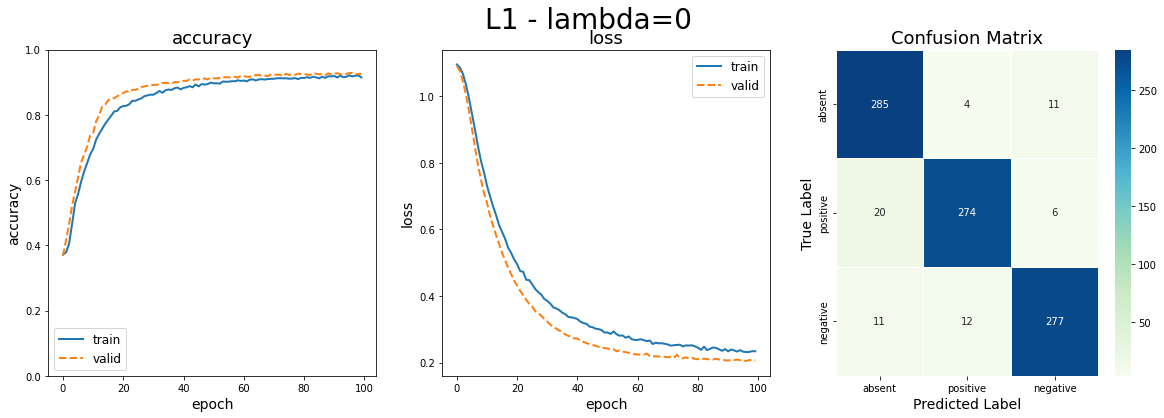

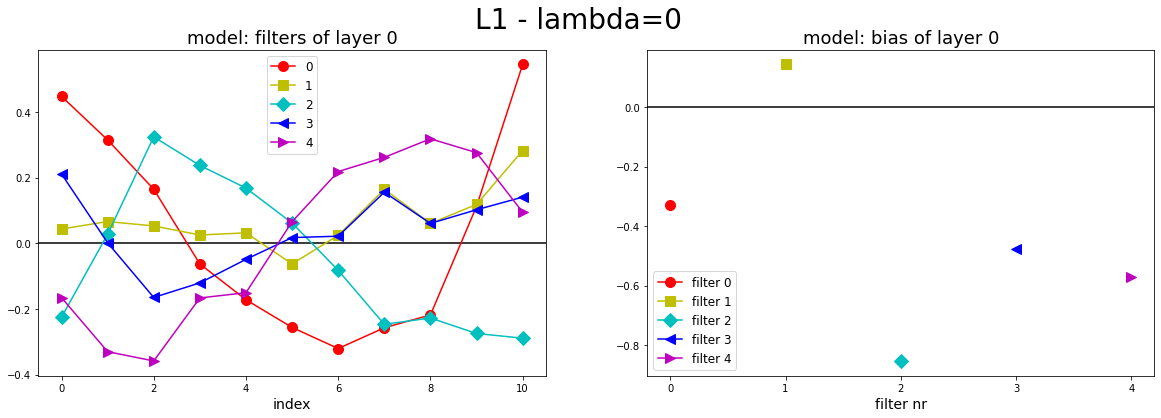

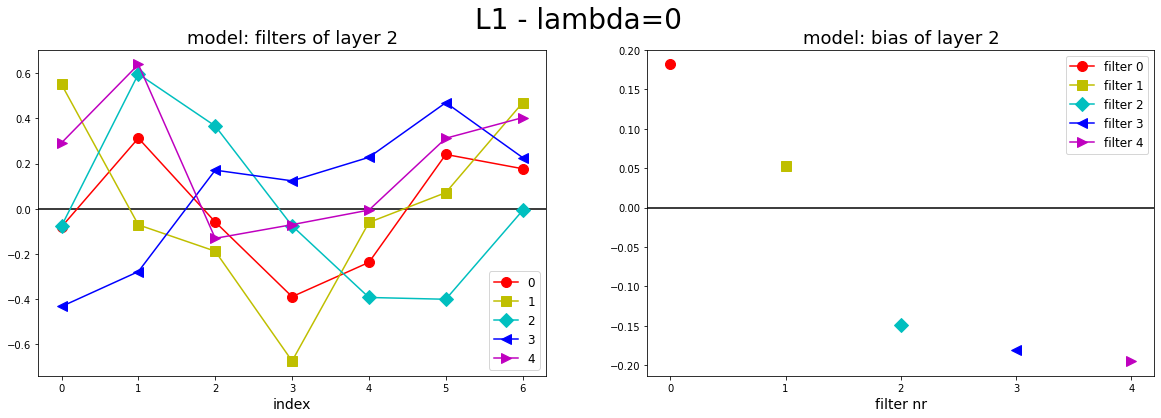

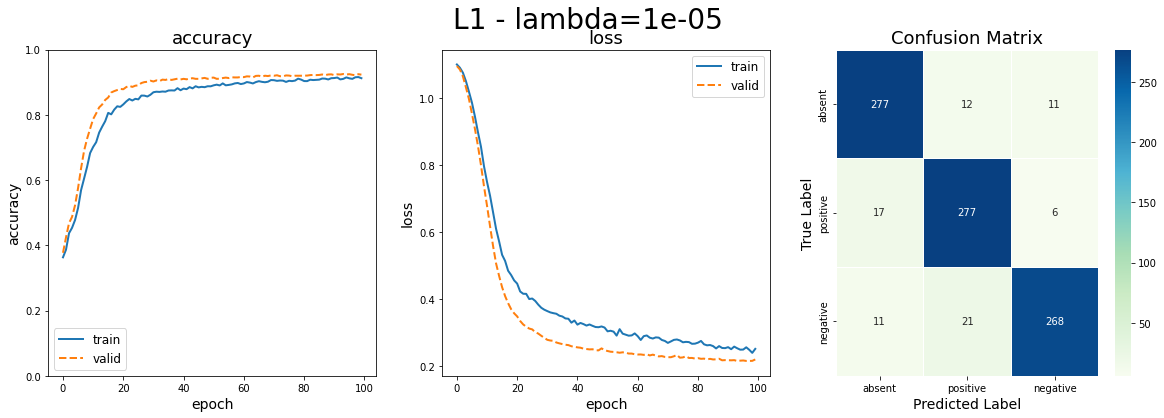

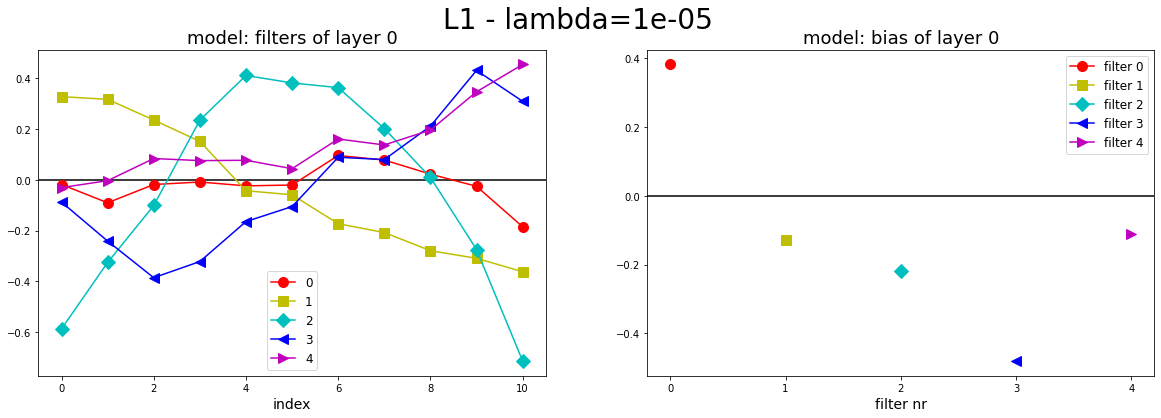

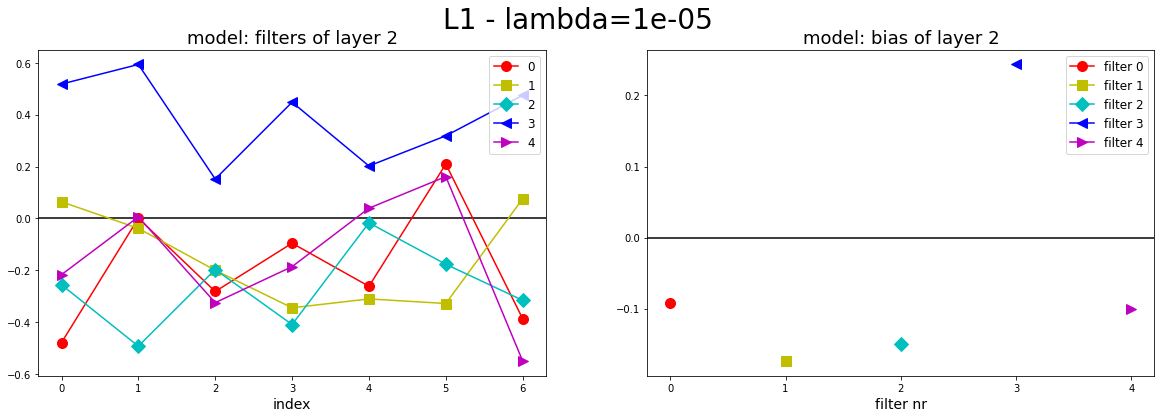

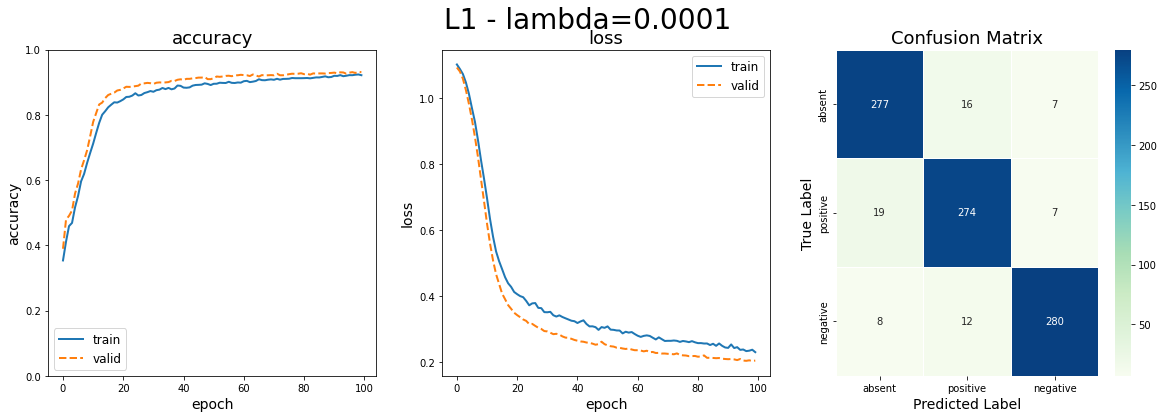

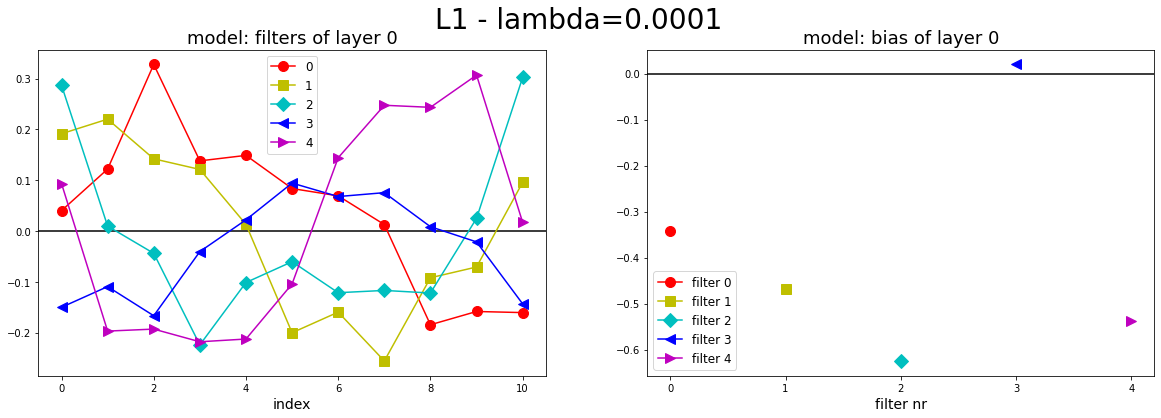

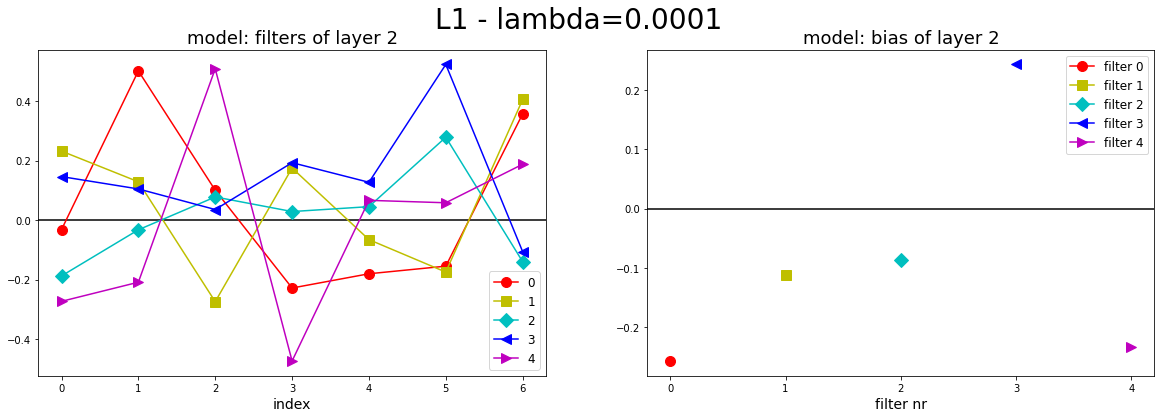

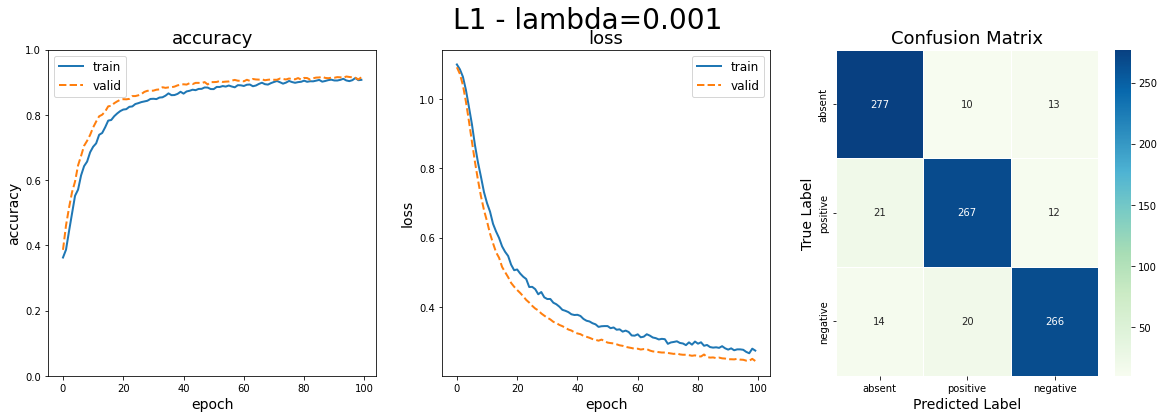

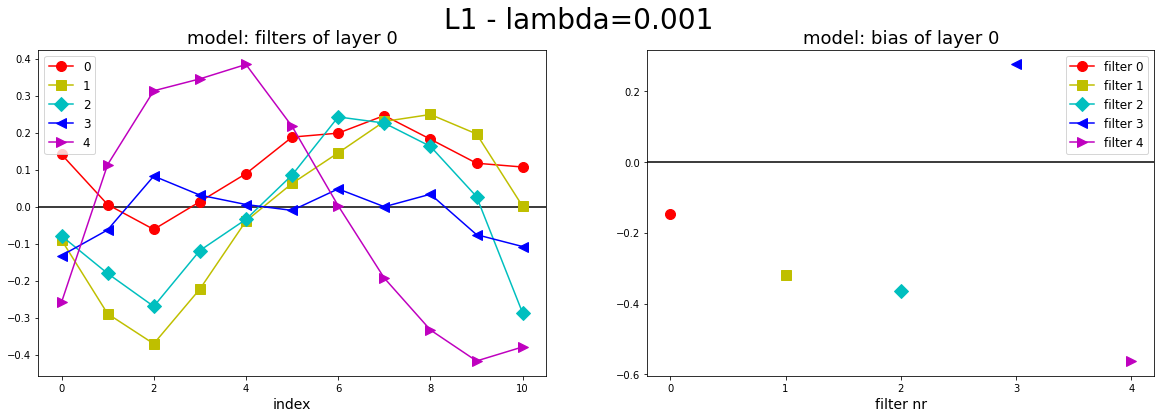

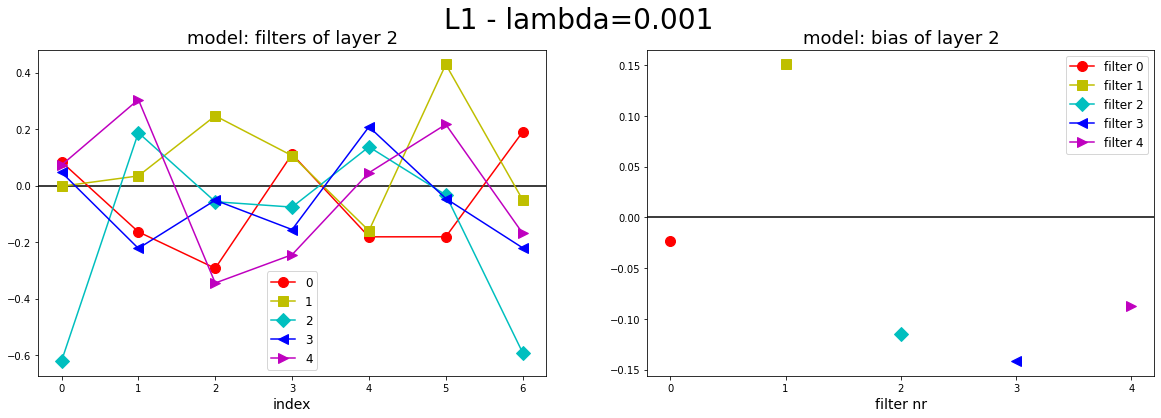

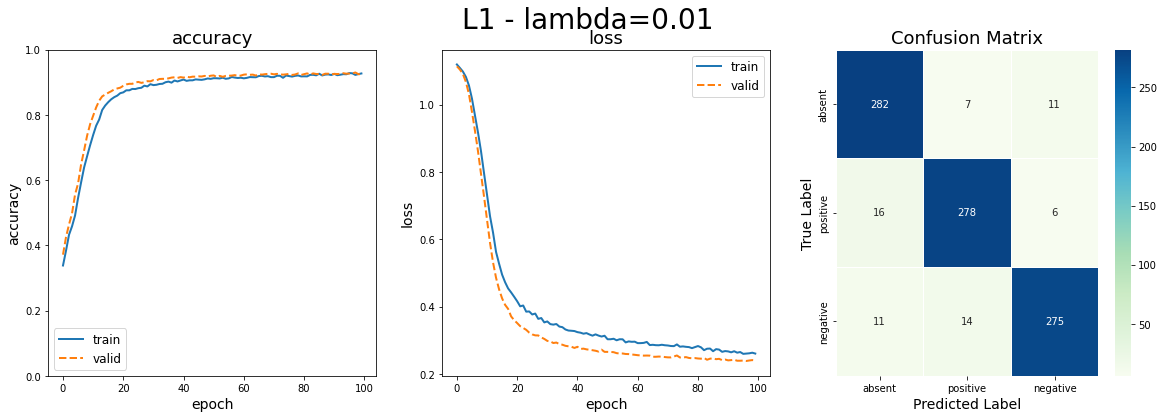

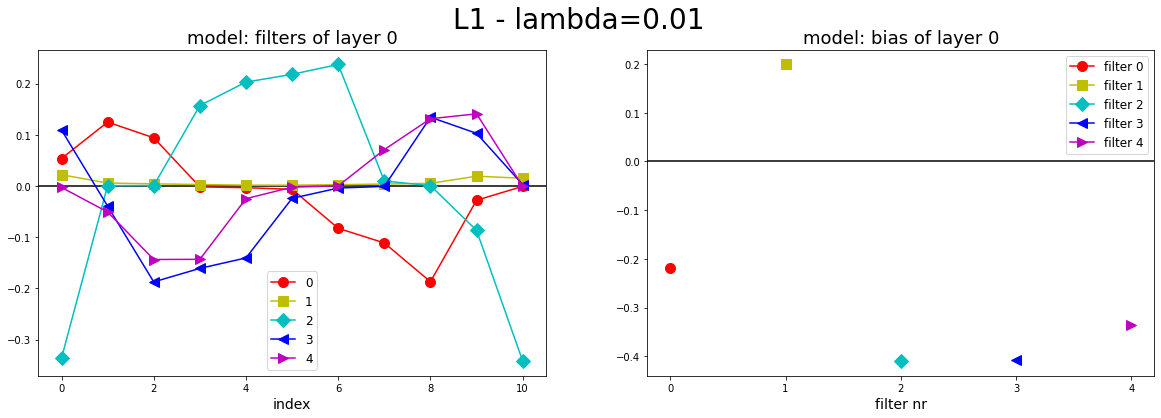

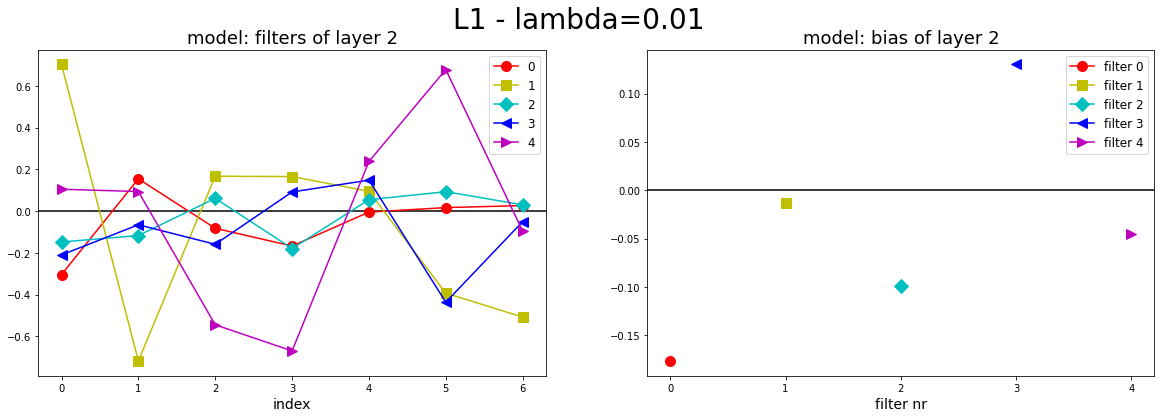

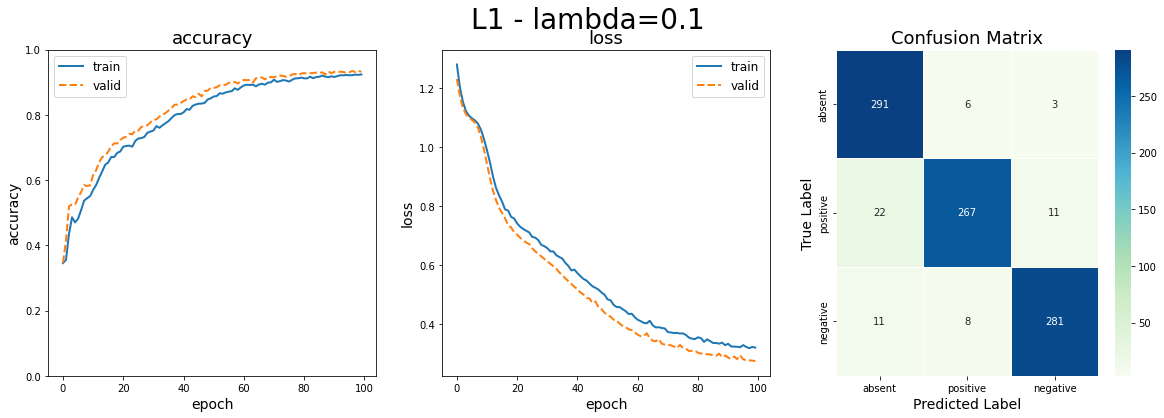

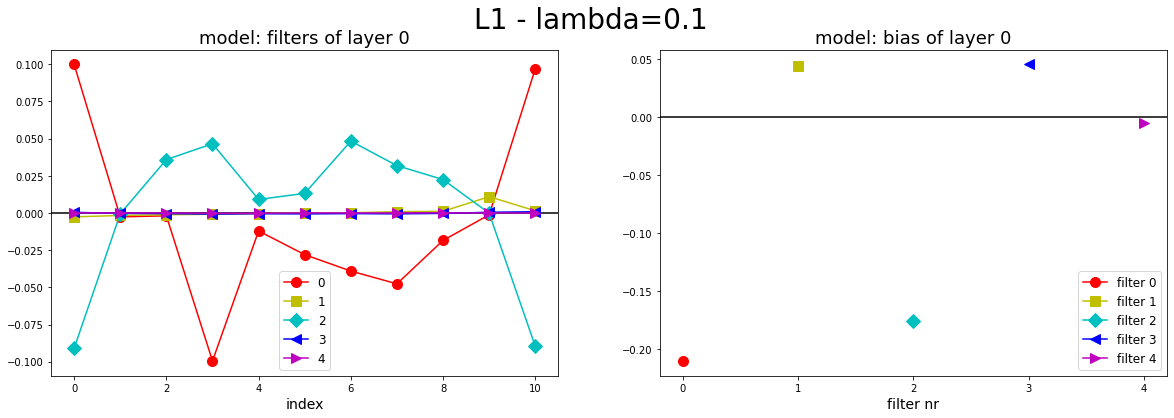

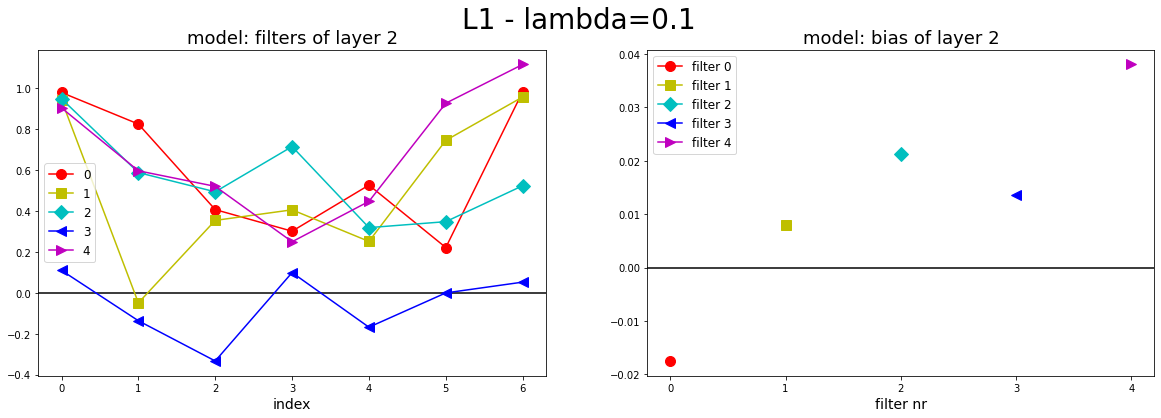

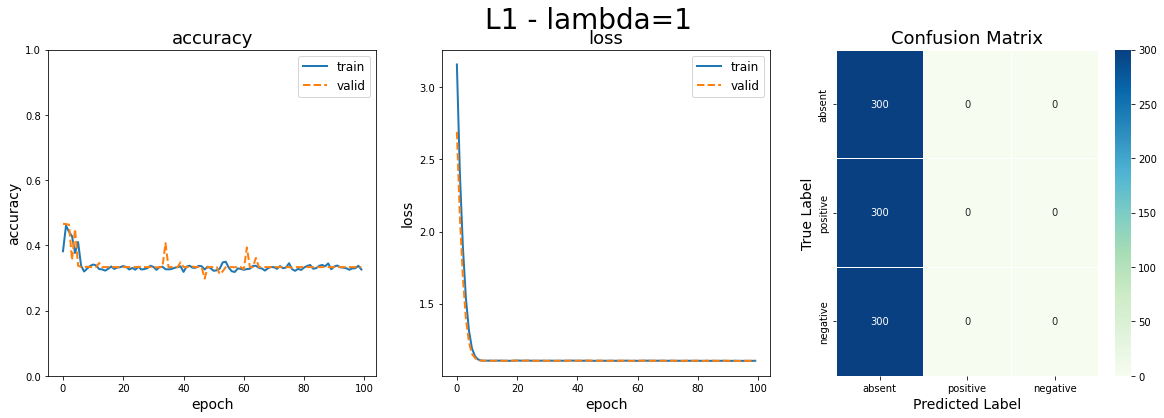

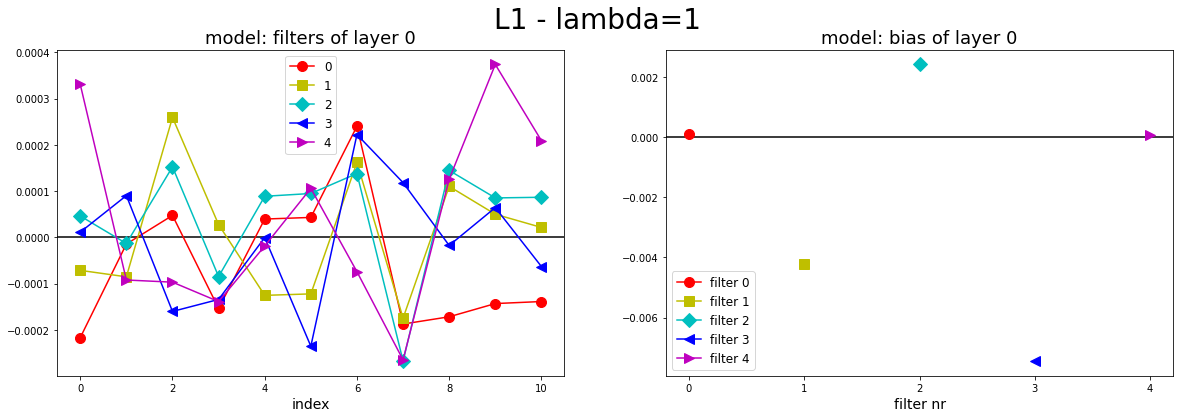

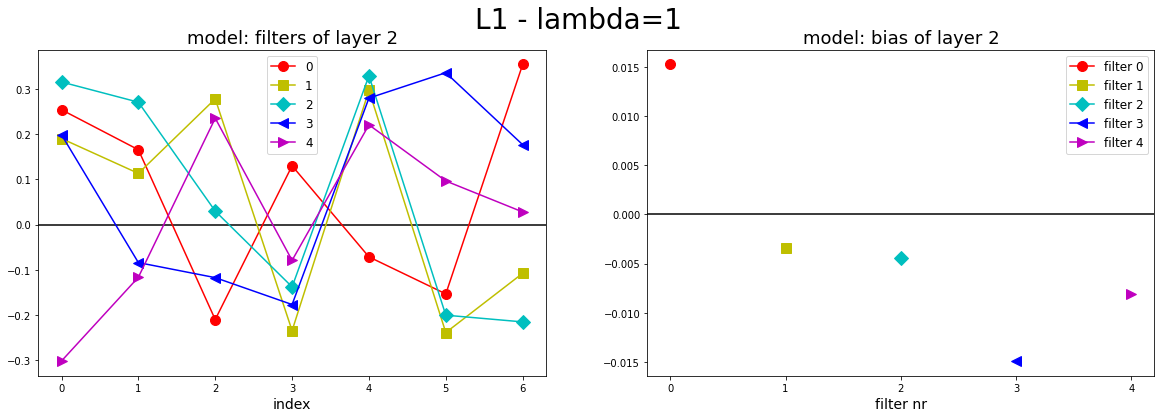

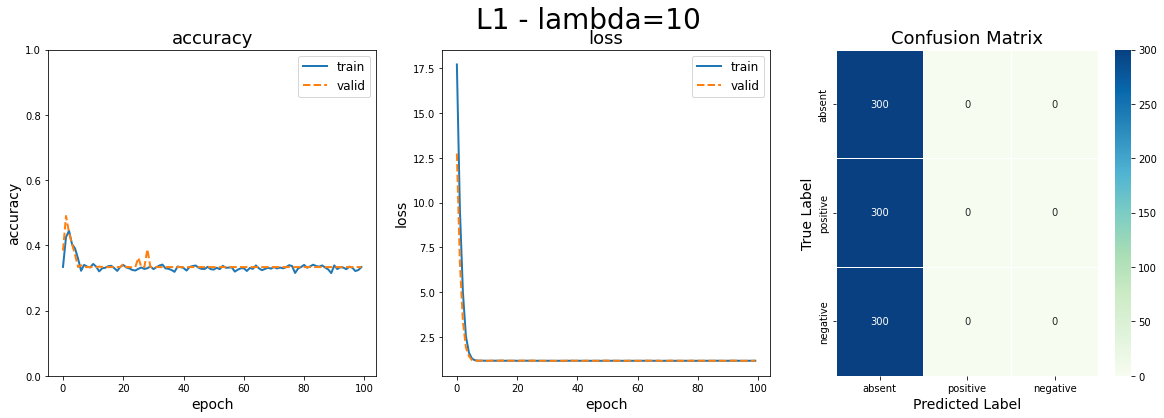

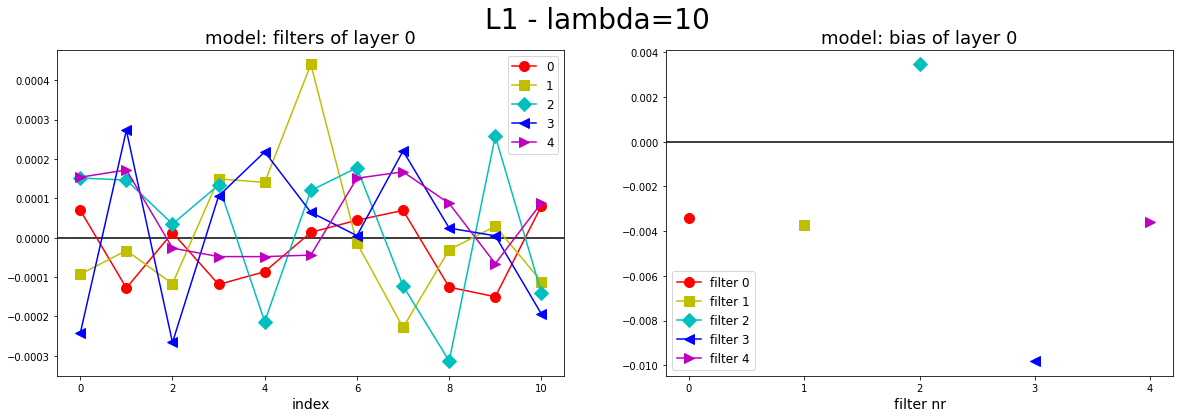

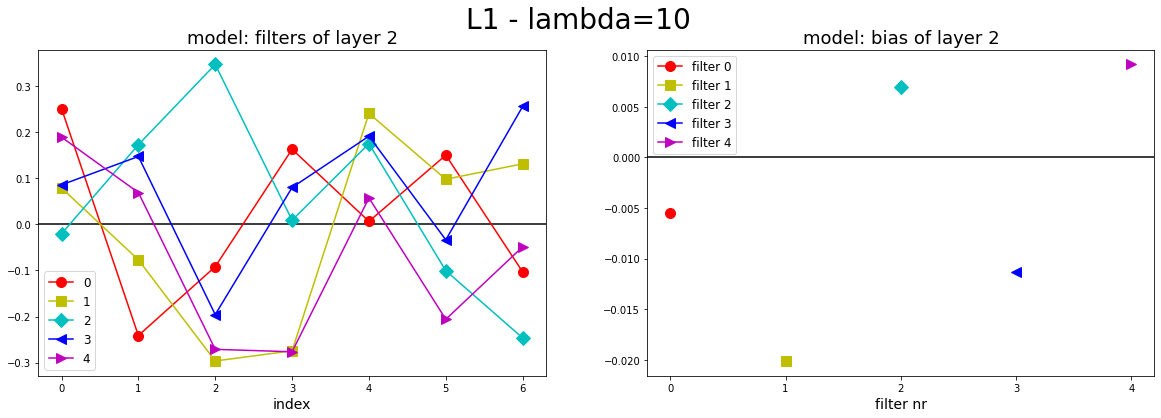

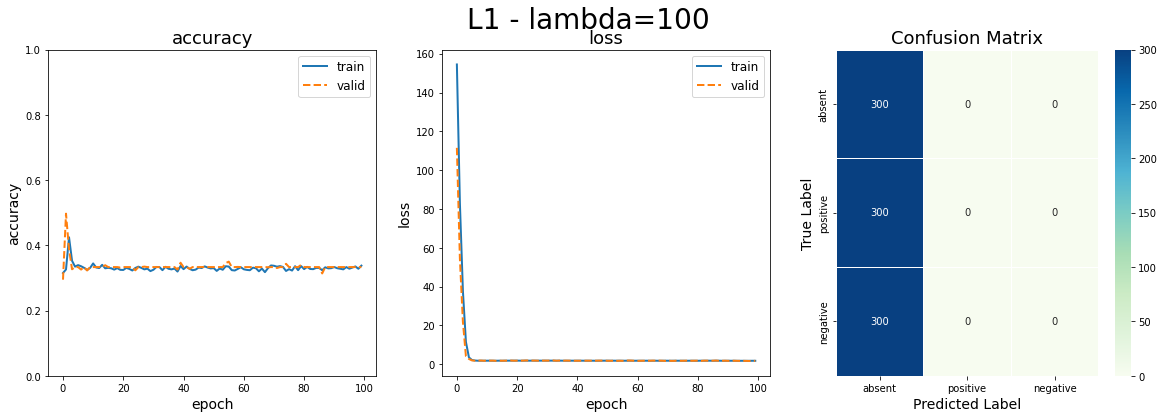

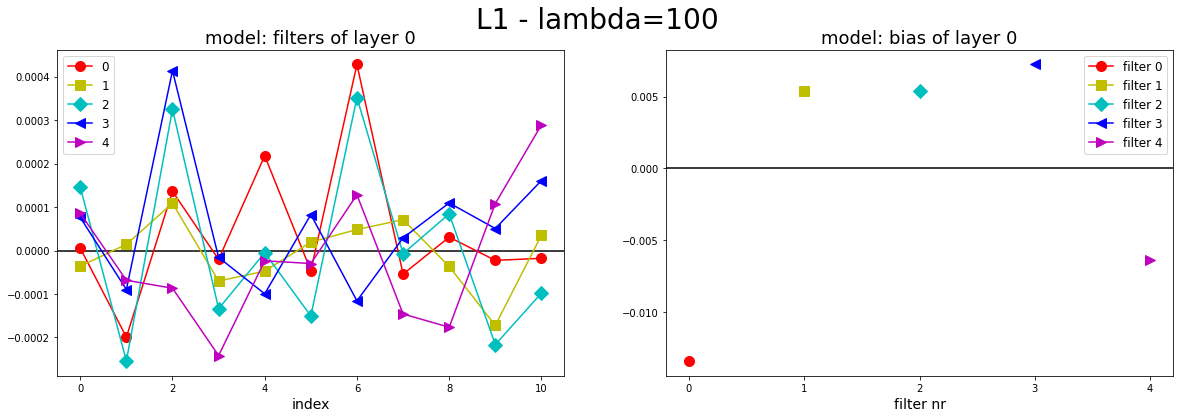

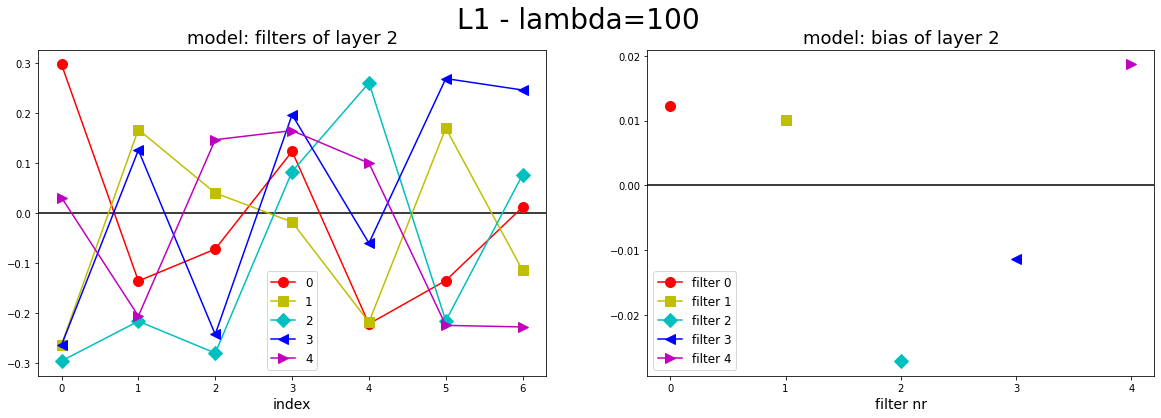

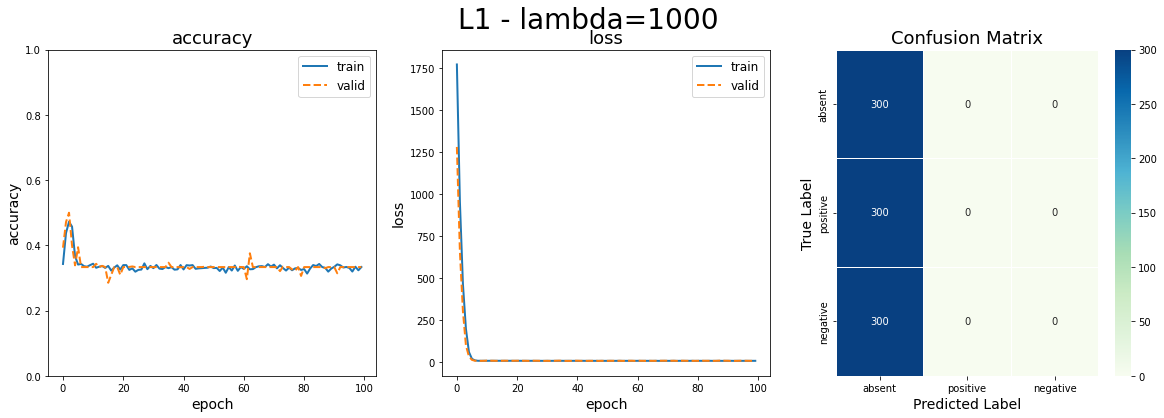

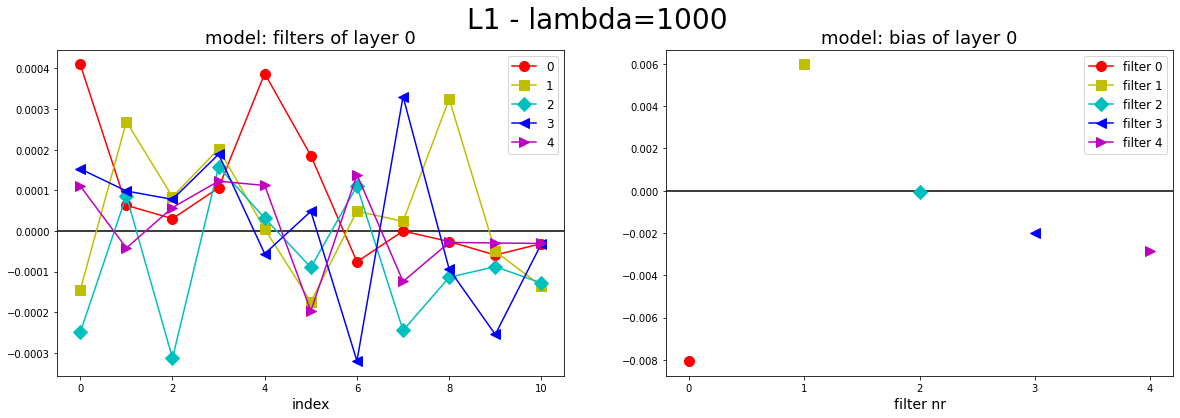

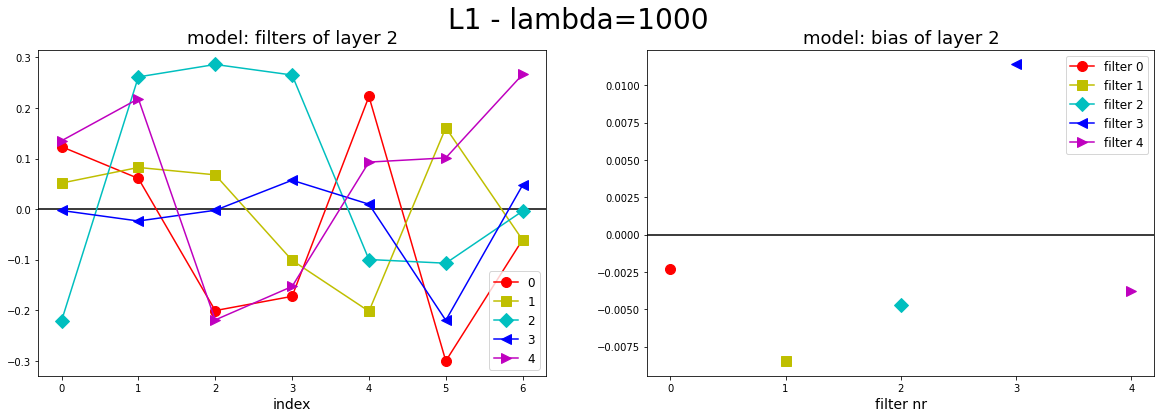

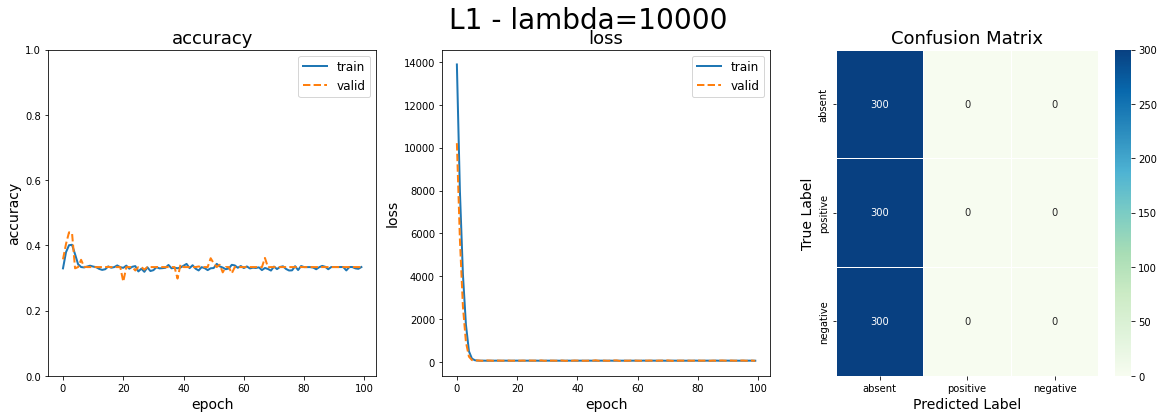

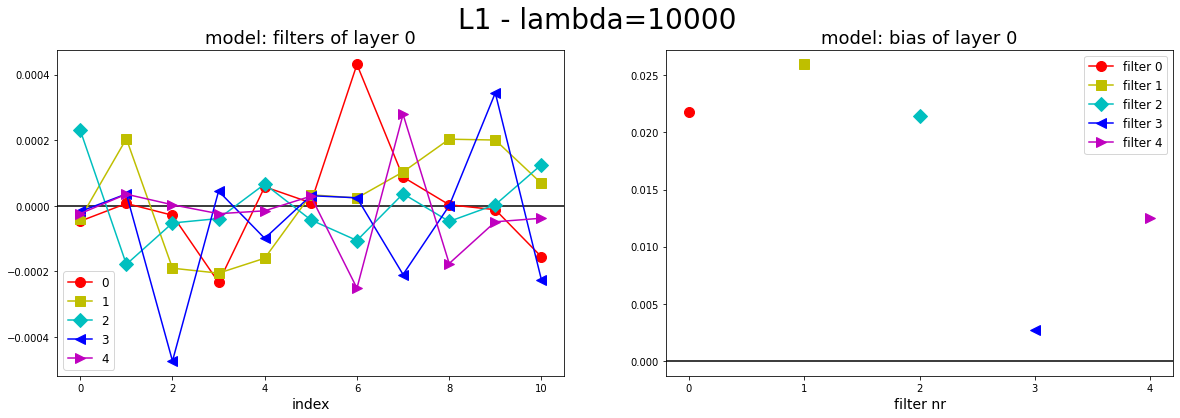

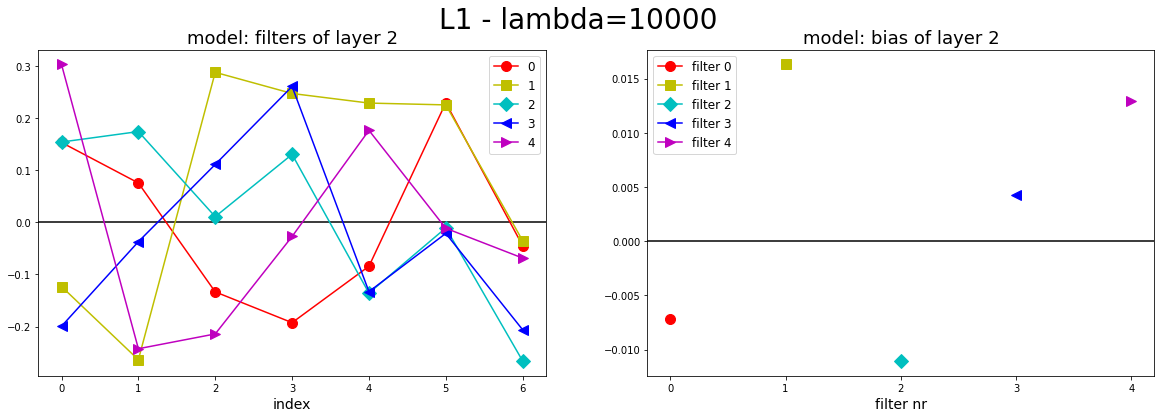

In [ ]:
for i, (fit, model) in enumerate(zip(fits_l1, models_l1)):

    fig = plt.figure(figsize=(20,6))
    fig.suptitle(f"L1 - lambda={lambdas[i]}", fontsize=28)
    ax  = plot_utils.plot_history(fit, fig, ncols=3)
    ax  = plot_utils.show_confusion_matrix(true=y_test_true_l1[i], pred=y_test_pred_l1[i], fig=fig, subplot_id=133)
    plt.show()

    fig = plt.figure(figsize=(20,6))
    fig.suptitle(f"L1 - lambda={lambdas[i]}", fontsize=28)
    ax  = plot_utils.plot_weights(model, 0, fig=fig)
    plt.show()
    fig = plt.figure(figsize=(20,6))
    fig.suptitle(f"L1 - lambda={lambdas[i]}", fontsize=28)
    ax  = plot_utils.plot_weights(model, 2, fig=fig)
    plt.show()


### L2 accuracy, loss, confusion matrix and weights

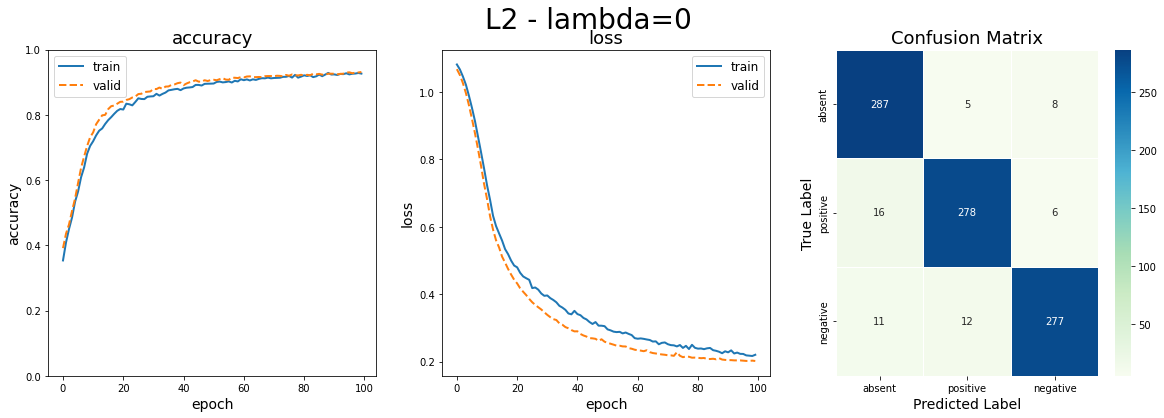

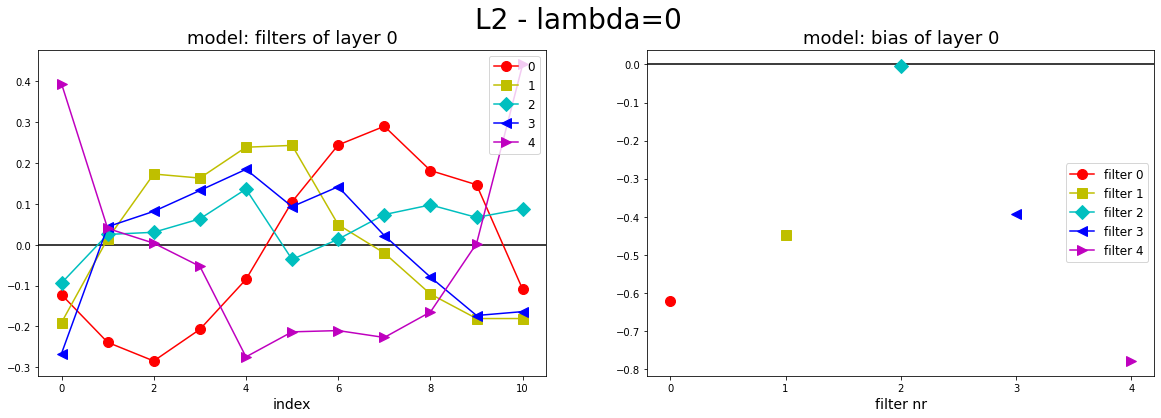

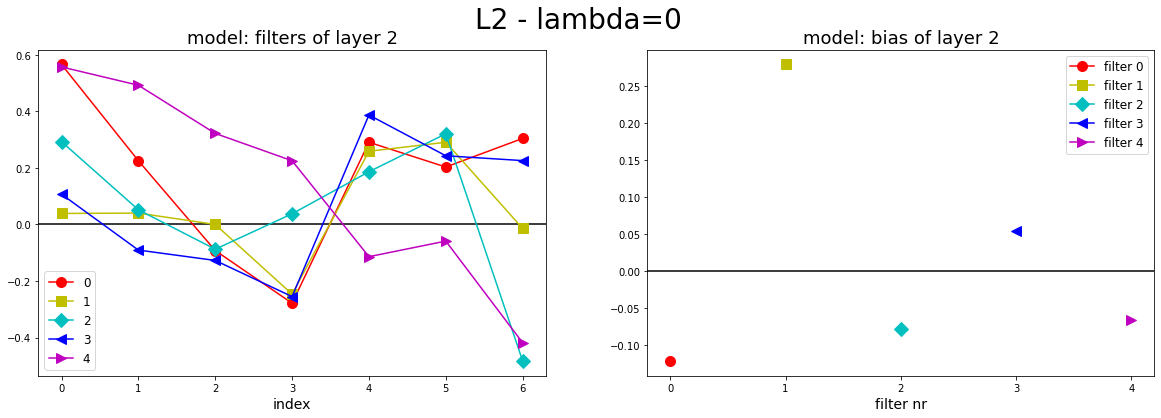

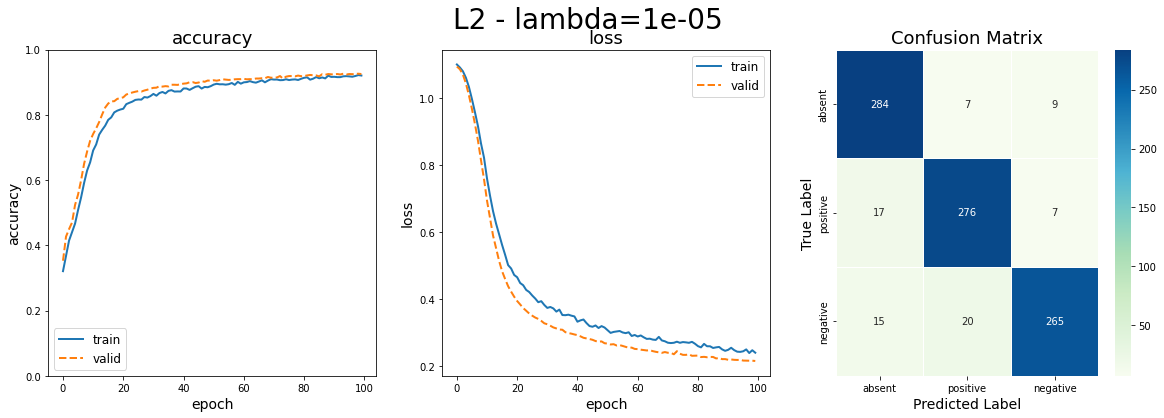

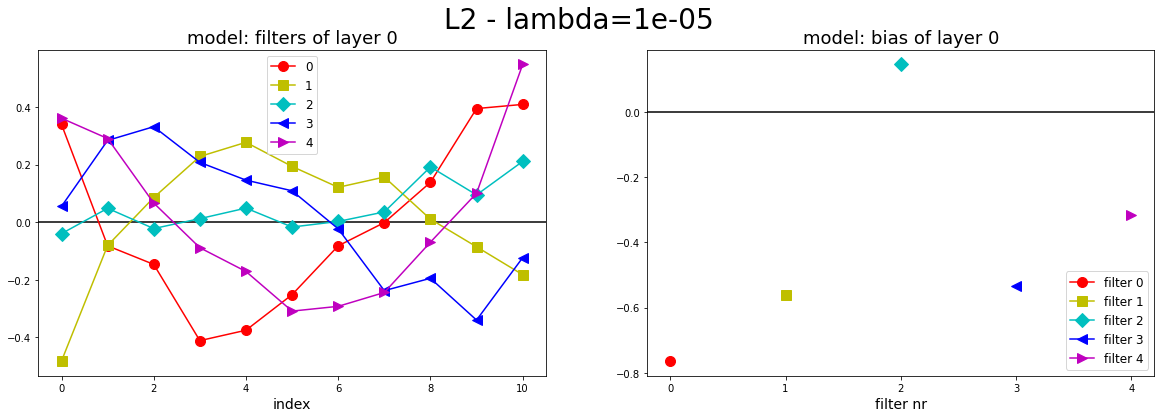

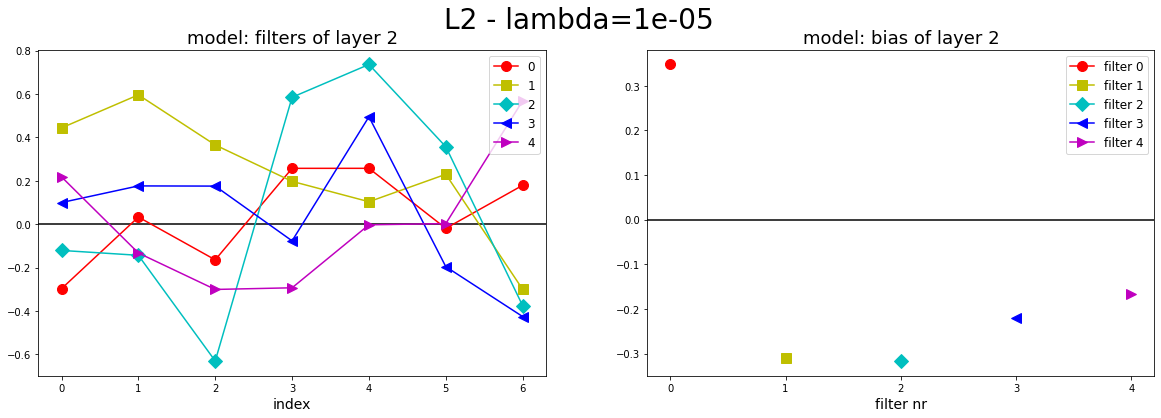

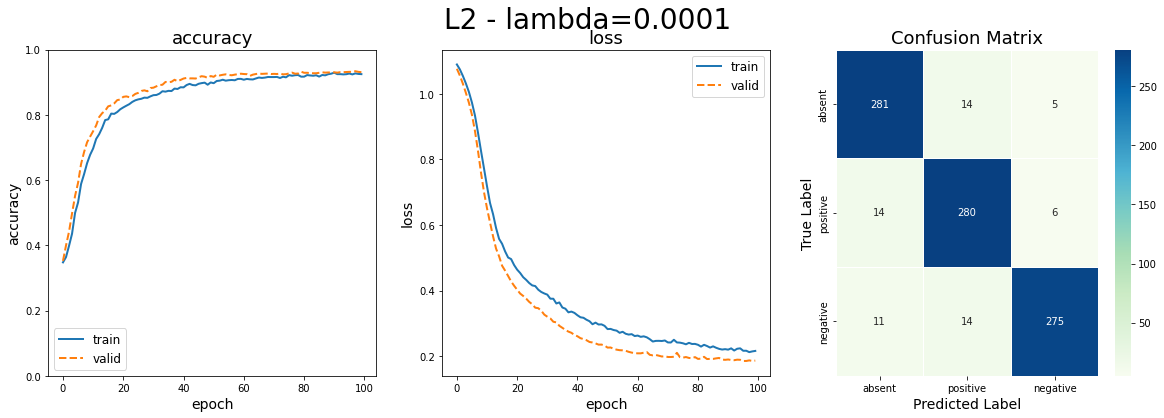

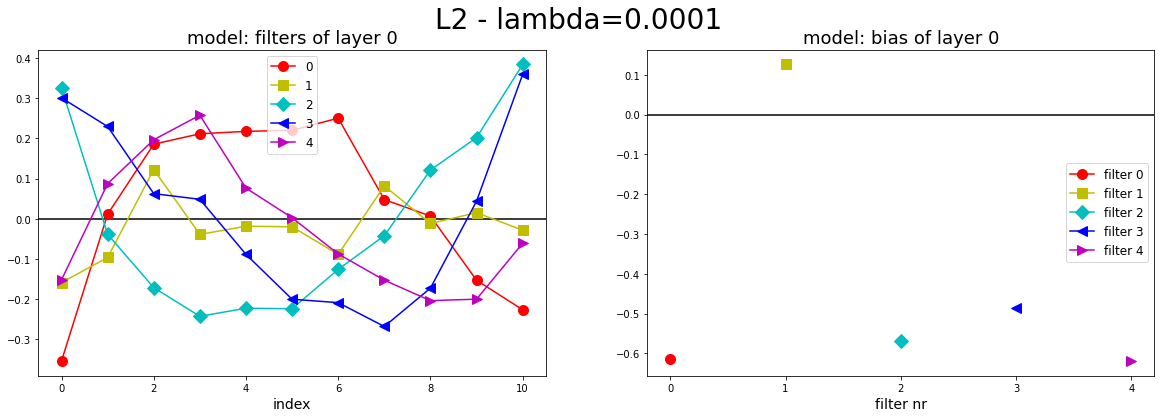

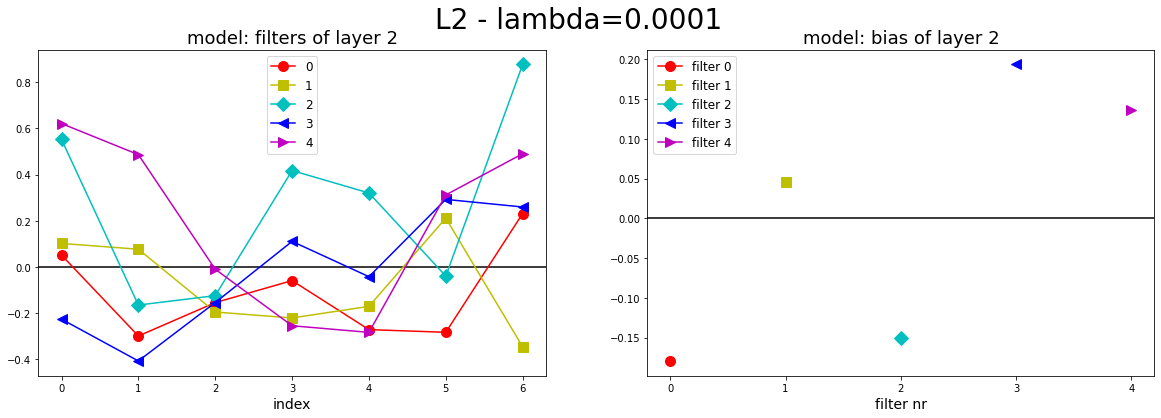

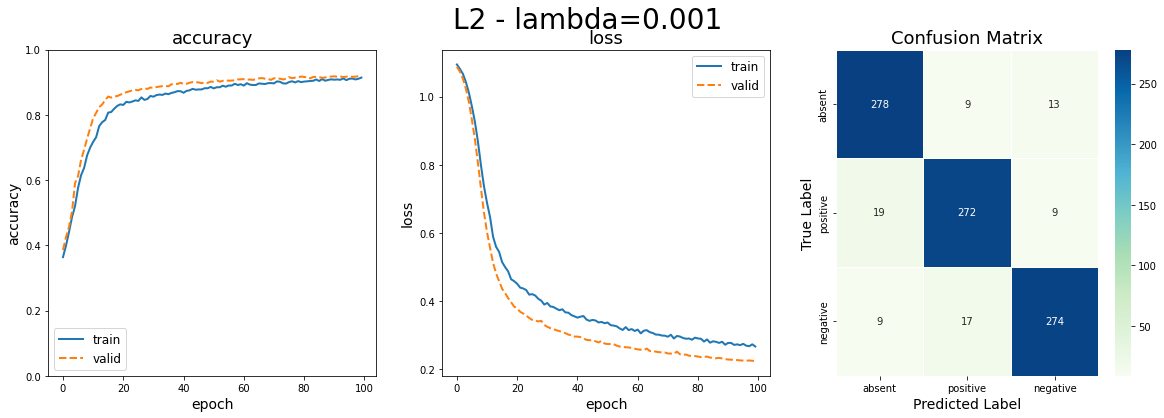

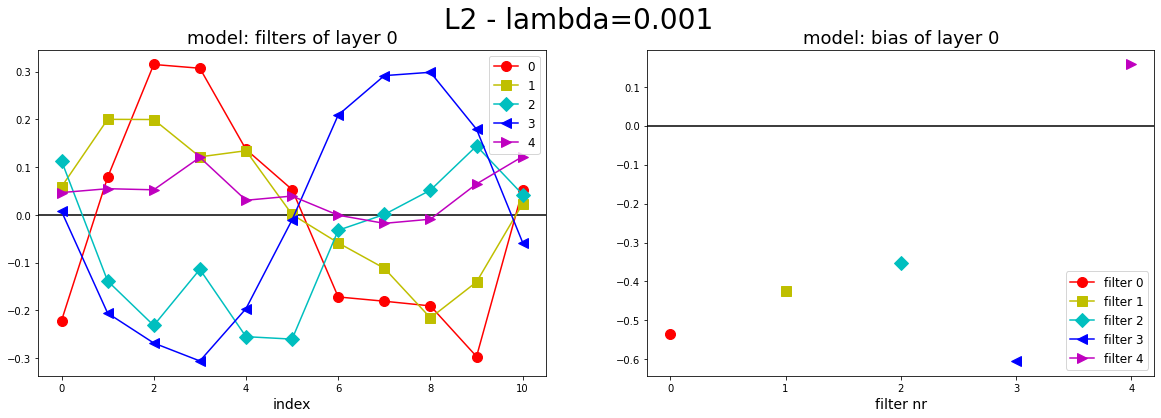

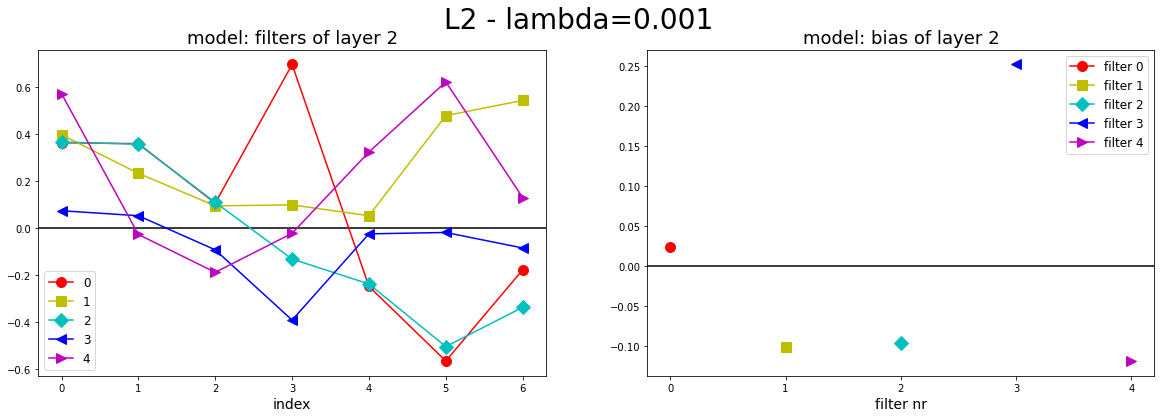

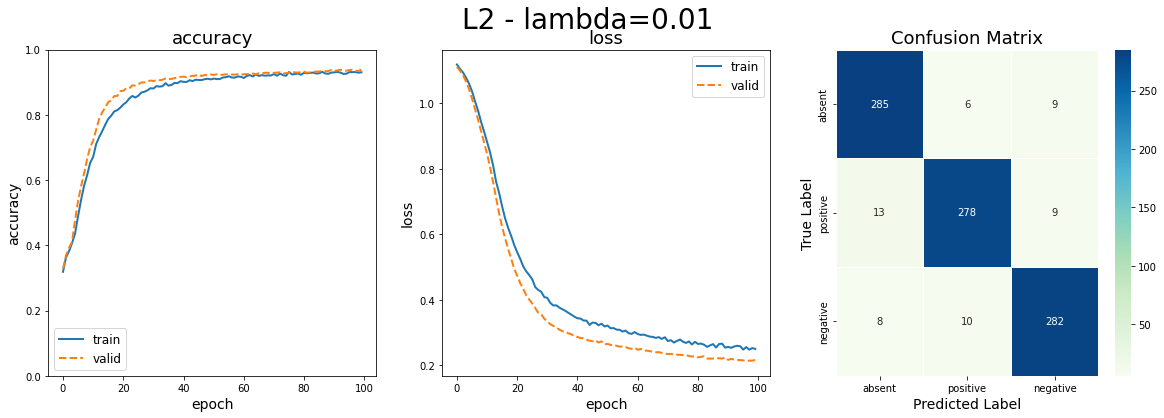

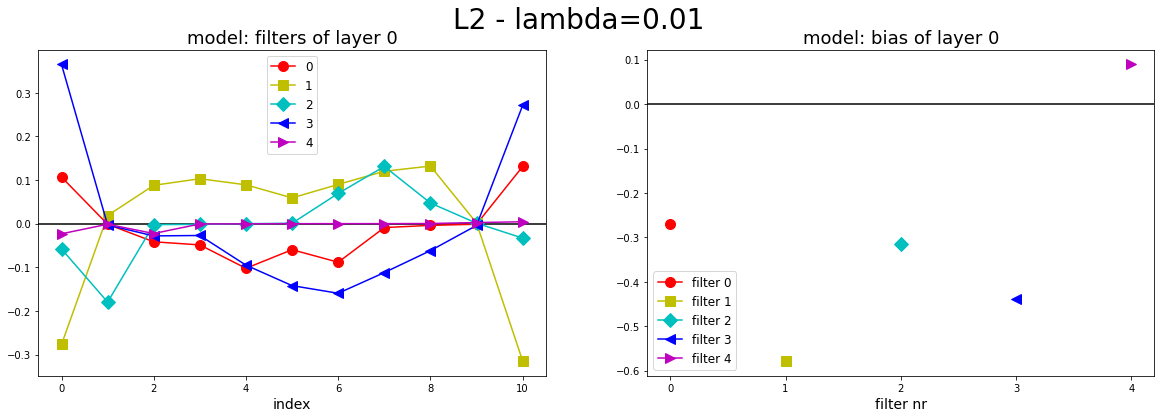

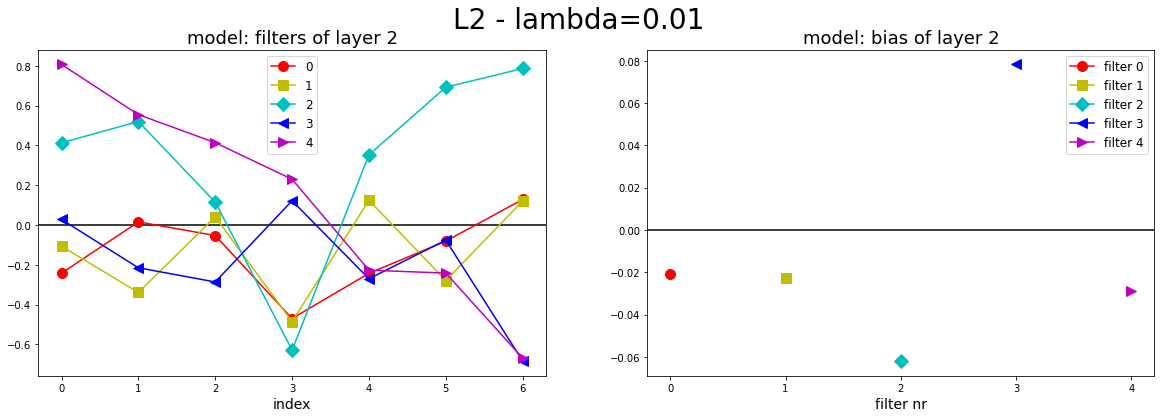

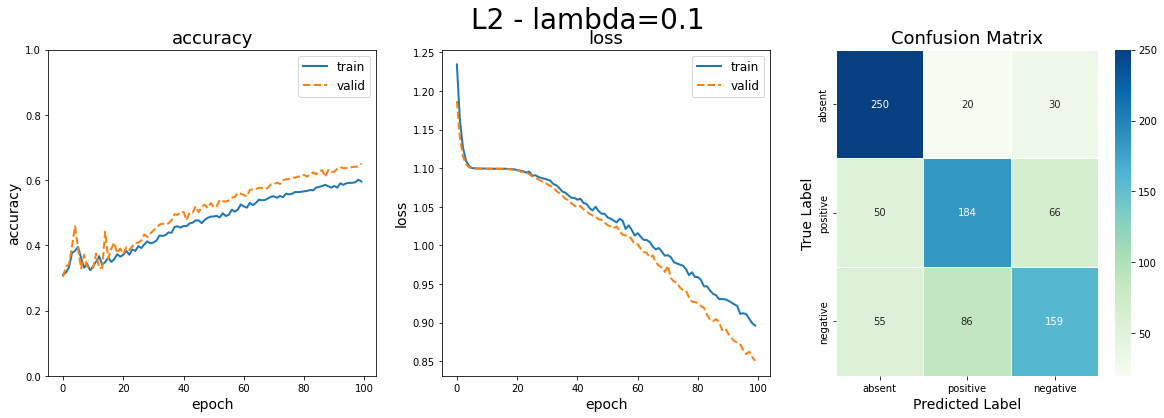

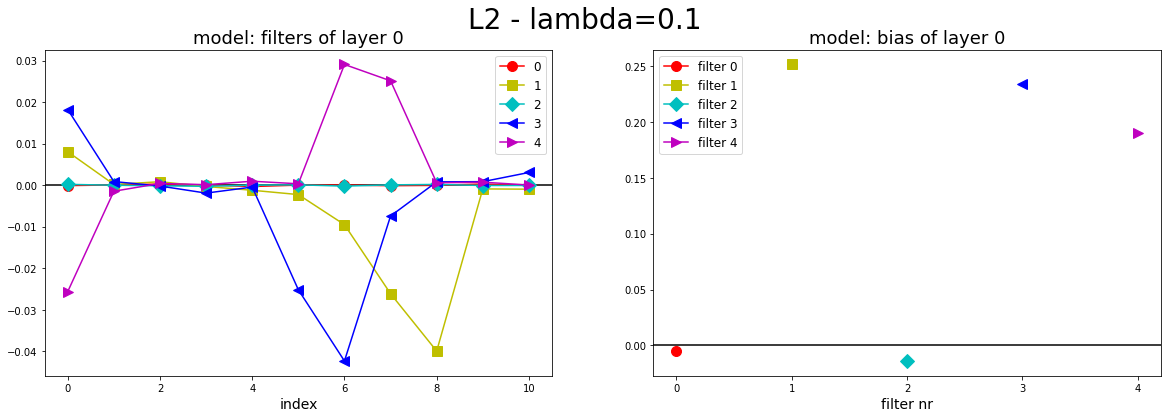

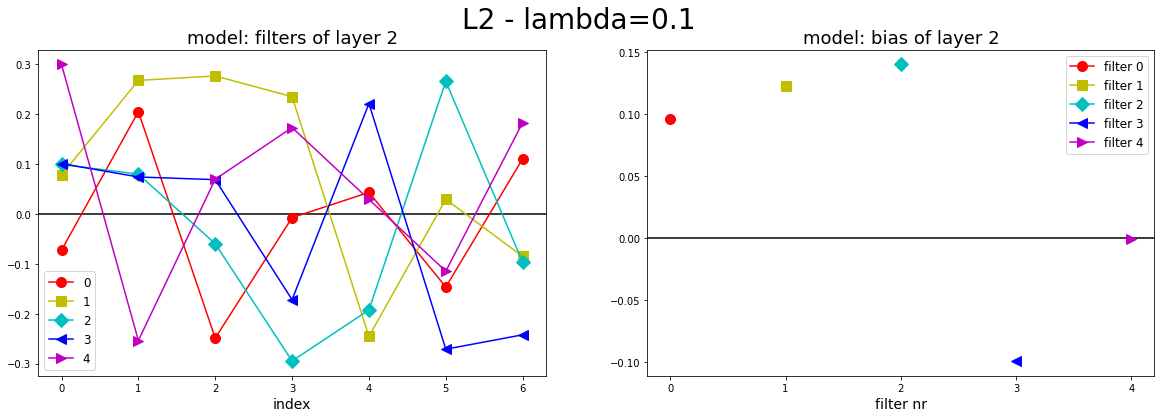

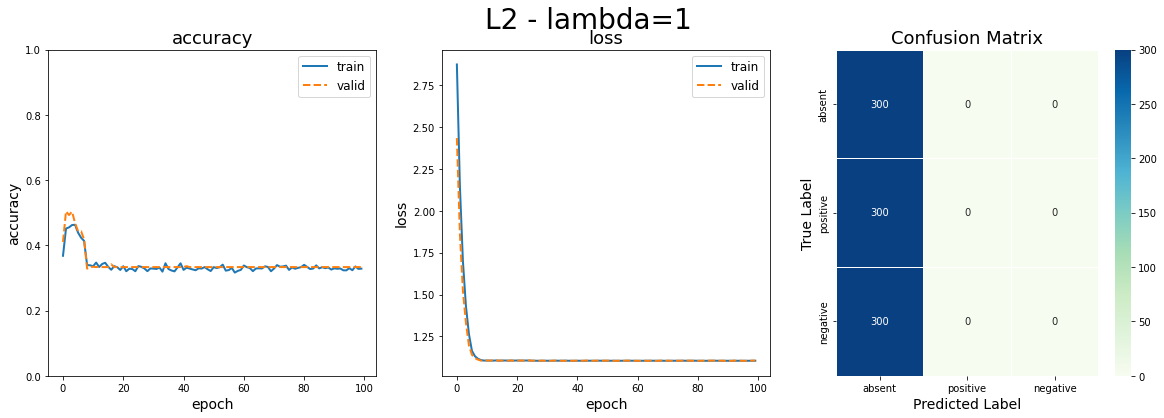

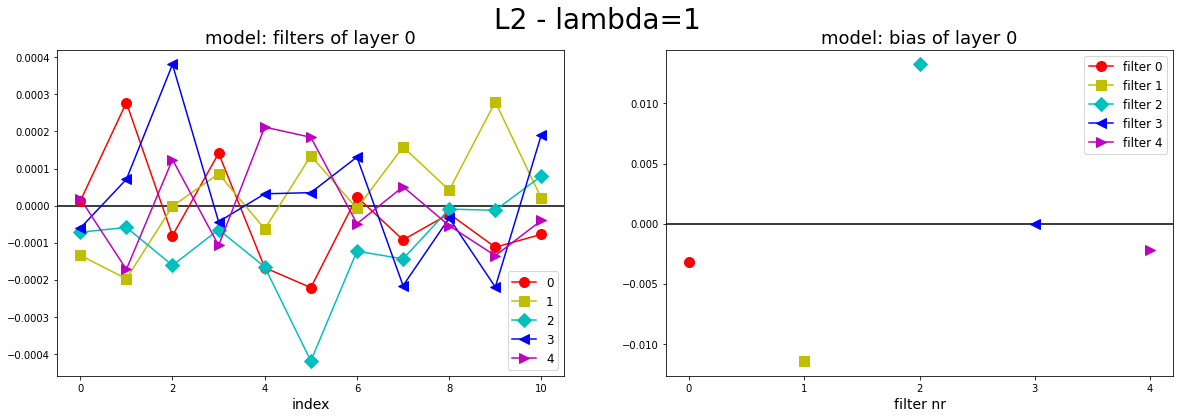

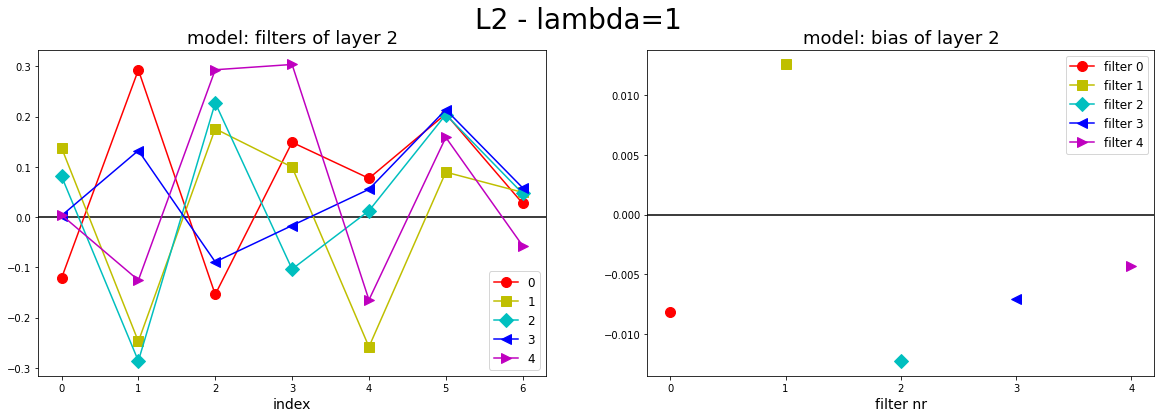

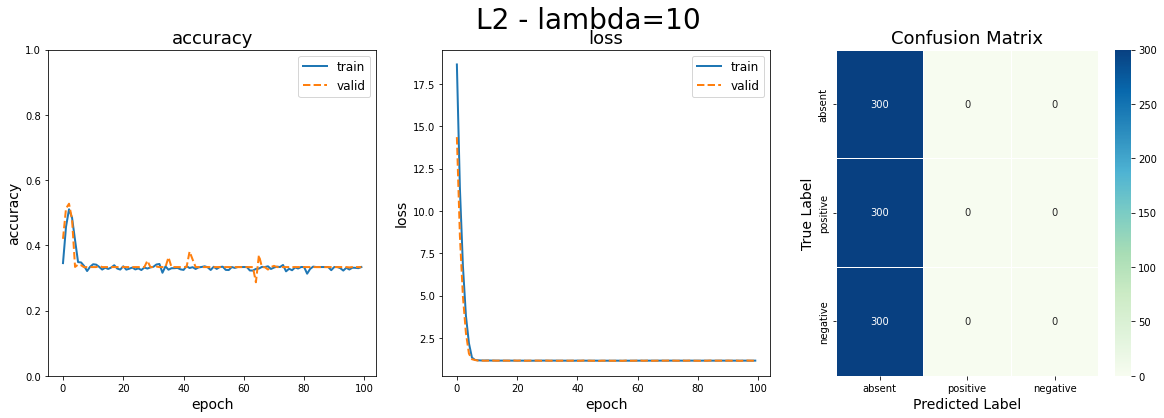

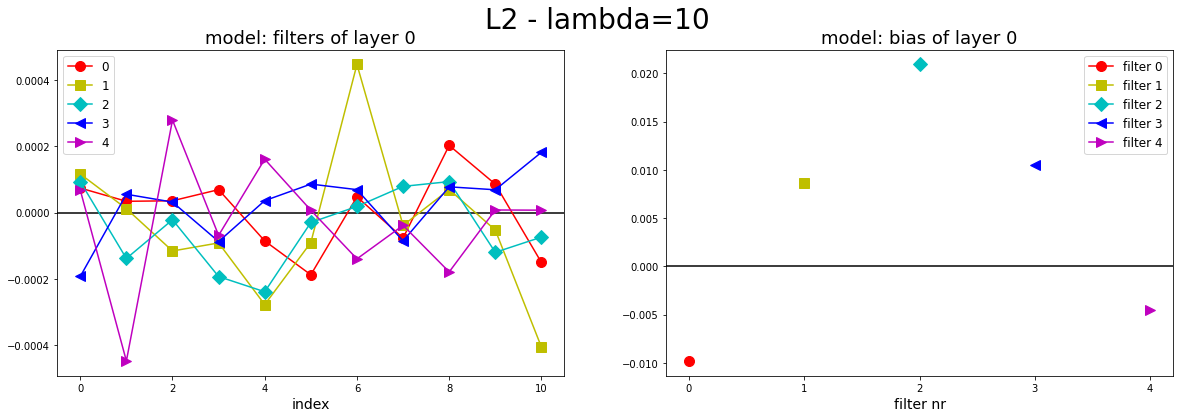

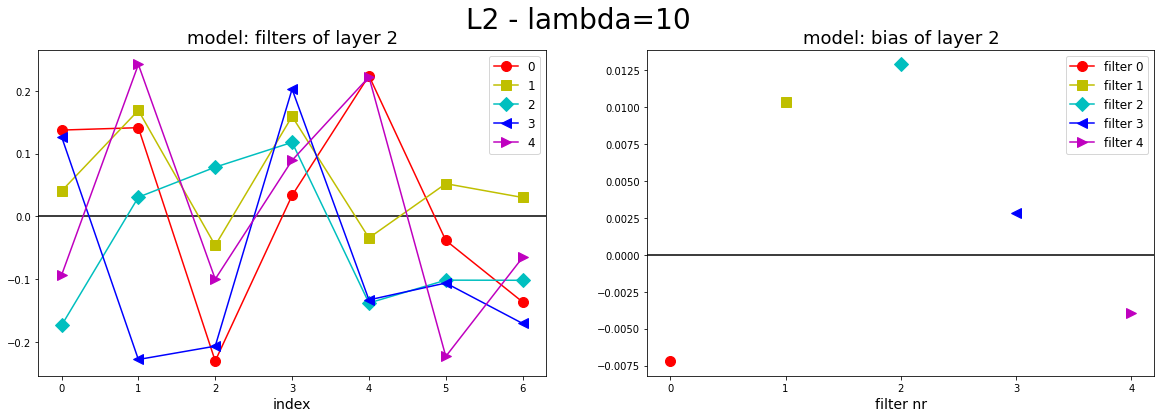

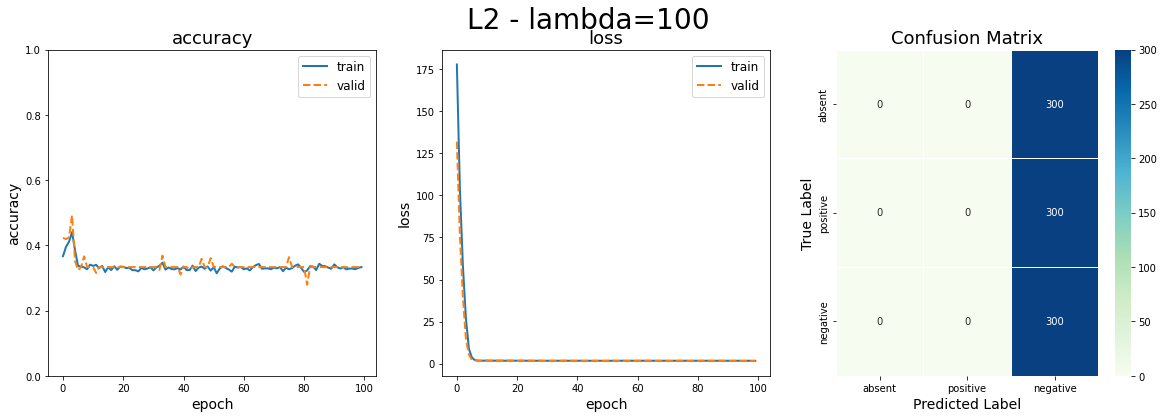

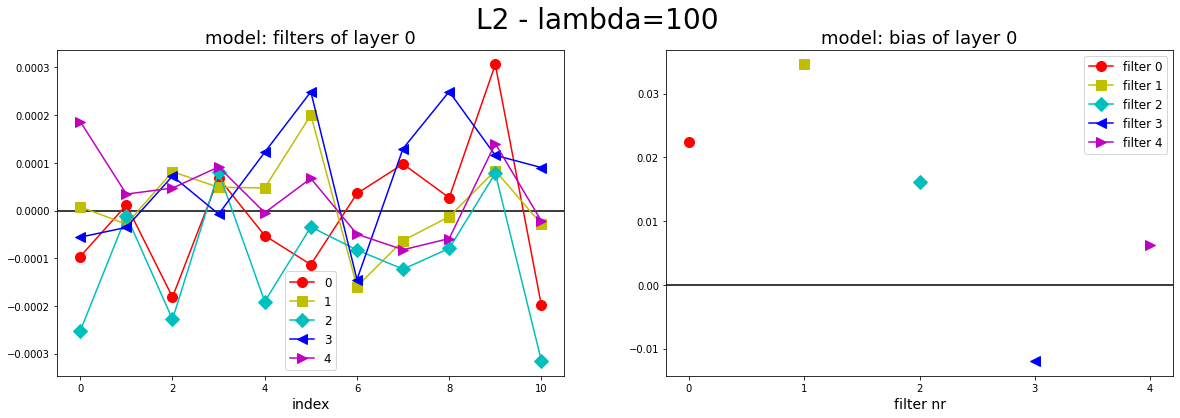

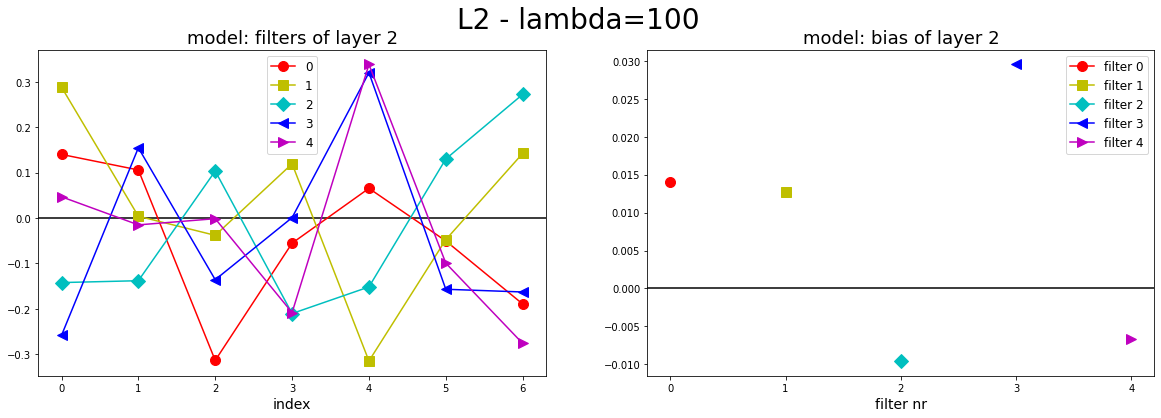

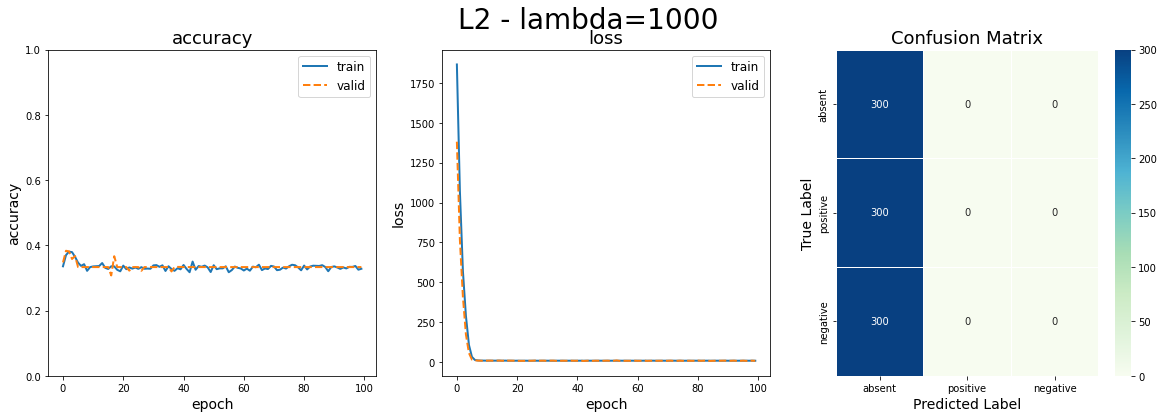

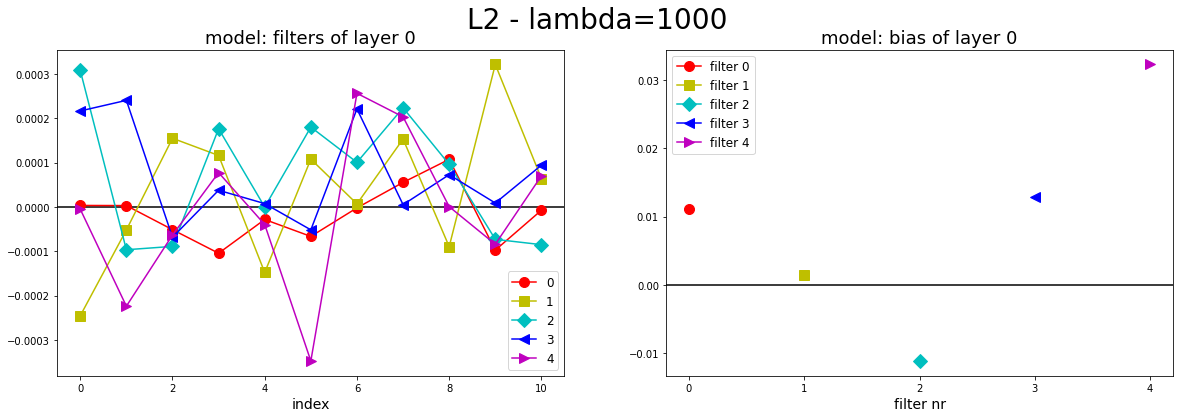

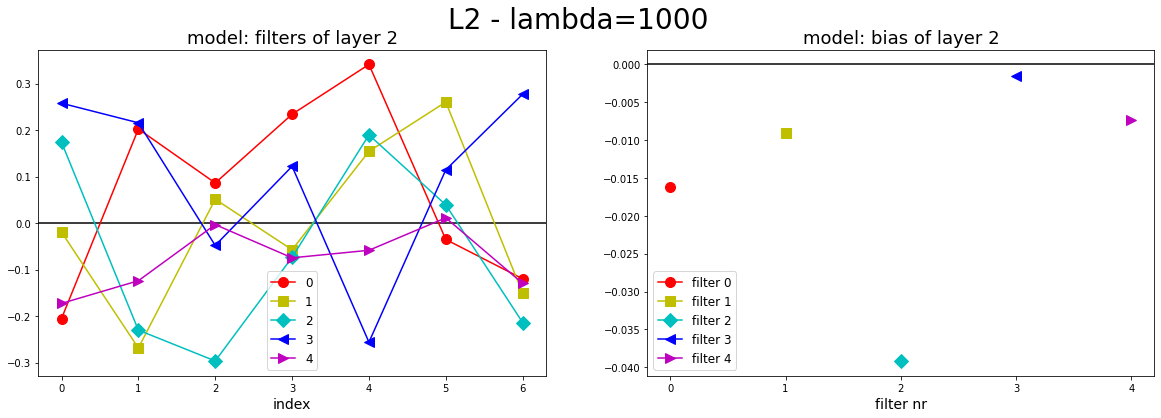

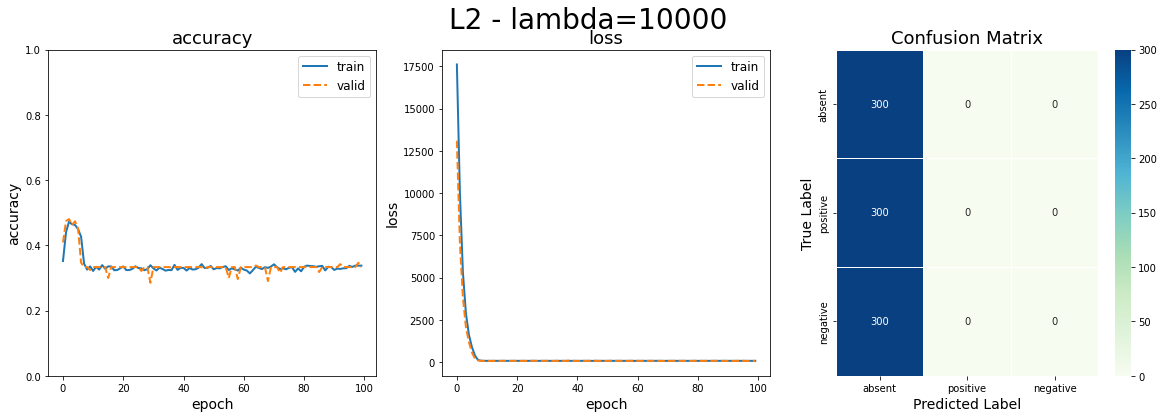

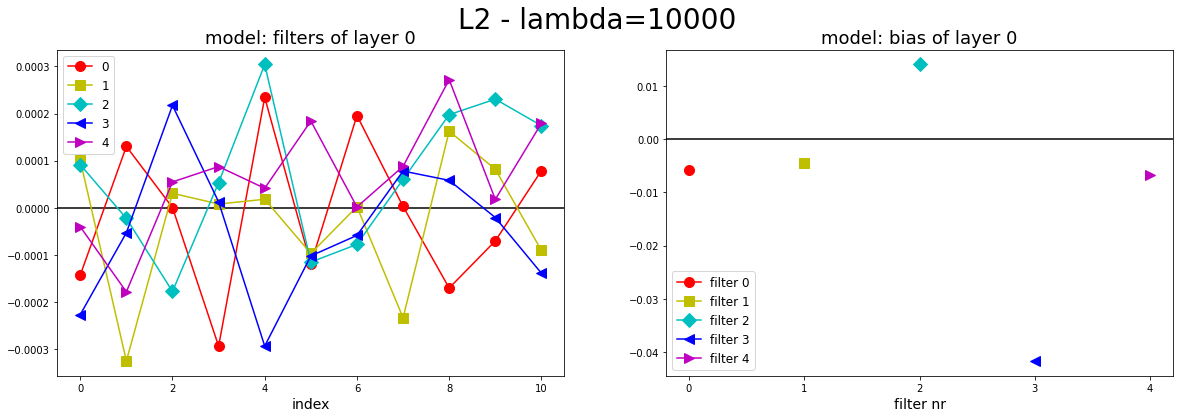

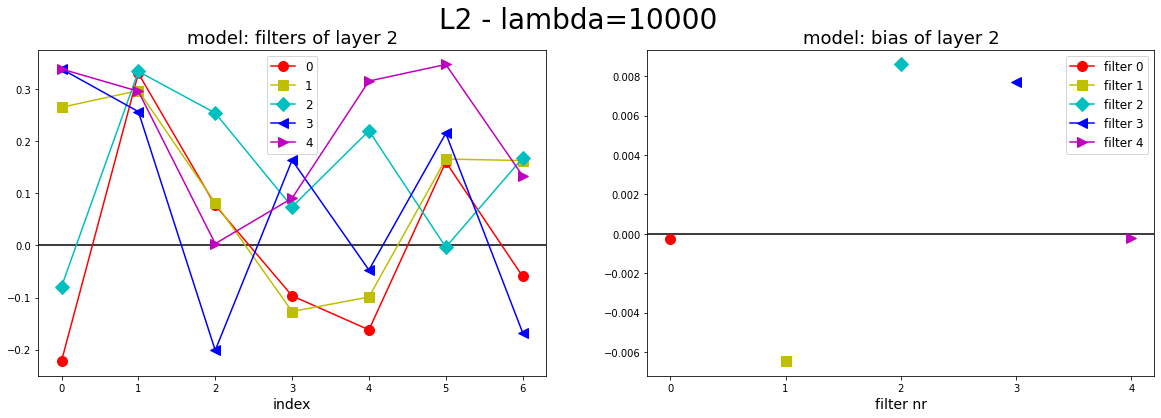

In [ ]:
for i, (fit, model) in enumerate(zip(fits_l2, models_l2)):

    fig = plt.figure(figsize=(20,6))
    fig.suptitle(f"L2 - lambda={lambdas[i]}", fontsize=28)
    ax  = plot_utils.plot_history(fit, fig, ncols=3)
    ax  = plot_utils.show_confusion_matrix(true=y_test_true_l2[i], pred=y_test_pred_l2[i], fig=fig, subplot_id=133)
    plt.show()

    fig = plt.figure(figsize=(20,6))
    fig.suptitle(f"L2 - lambda={lambdas[i]}", fontsize=28)
    ax  = plot_utils.plot_weights(model, 0, fig=fig)
    plt.show()
    fig = plt.figure(figsize=(20,6))
    fig.suptitle(f"L2 - lambda={lambdas[i]}", fontsize=28)
    ax  = plot_utils.plot_weights(model, 2, fig=fig)
    plt.show()

### Summary loss and accuracy trend over $\lambda_{reg}$

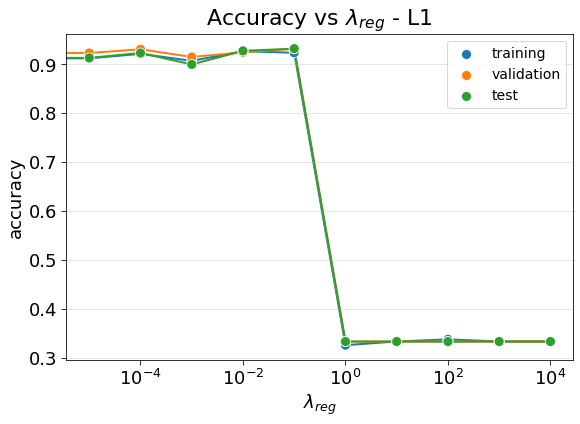

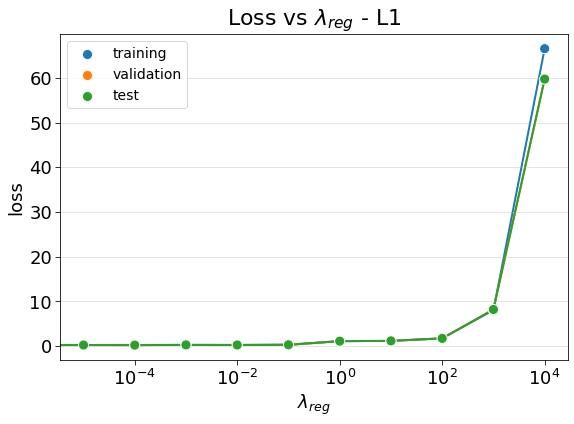

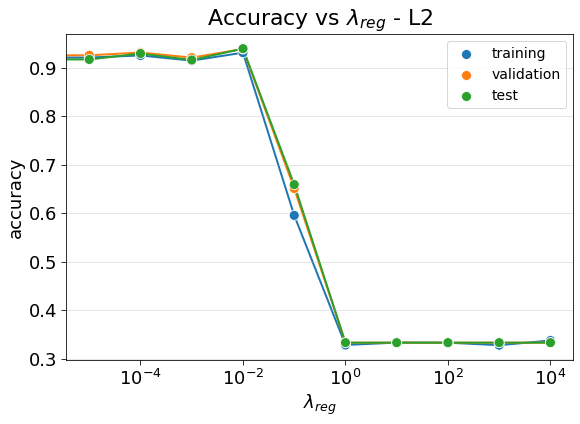

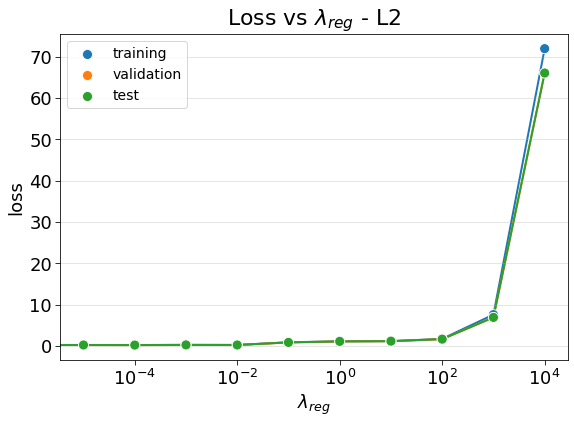

In [ ]:
final_train_acc = [fit.history["accuracy"][-1]     for fit in fits_l1]
final_valid_acc = [fit.history["val_accuracy"][-1] for fit in fits_l1]
test_acc        = [test[1]                 for test in tests_l1]

final_train_loss = [fit.history["loss"][-1]     for fit in fits_l1]
final_valid_loss = [fit.history["val_loss"][-1] for fit in fits_l1]
test_loss        = [test[0]             for test in tests_l1]

fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(121)

ax1 = plot_utils.scatter_results(
    parameter=lambdas,
    result=final_train_acc,
    fig=fig,
    ax=ax1,
    label="training",
    par_label="$\lambda_{reg}$",
    metric_label="accuracy",
    color="tab:blue",
    lw=2,
    ls="-",
    title="Accuracy vs $\lambda_{reg}$ - L1",
    #ms=final_train_loss,
)

ax1 = plot_utils.scatter_results(
    parameter=lambdas,
    result=final_valid_acc,
    fig=fig,
    ax=ax1,
    label="validation",
    par_label="$\lambda_{reg}$",
    metric_label="accuracy",
    color="tab:orange",
    lw=2,
    ls="-",
    title="Accuracy vs $\lambda_{reg}$ - L1",
    #ms=final_valid_loss,
)

ax1 = plot_utils.scatter_results(
    parameter=lambdas,
    result=test_acc,
    fig=fig,
    ax=ax1,
    label="test",
    par_label="$\lambda_{reg}$",
    metric_label="accuracy",
    color="tab:green",
    lw=2,
    ls="-",
    title="Accuracy vs $\lambda_{reg}$ - L1",
    #ms=test_loss,
)

ax1.set_axisbelow(True)
ax1.set_xscale('log')
ax1.grid("y", "major", axis="y", alpha=0.4)

plt.show()

fig = plt.figure(figsize=(20,6)) 
ax2 = fig.add_subplot(122) 

ax2 = plot_utils.scatter_results(
    parameter=lambdas,
    result=final_train_loss,
    fig=fig,
    ax=ax2,
    label="training",
    par_label="$\lambda_{reg}$",
    metric_label="loss",
    color="tab:blue",
    lw=2,
    ls="-",
    title="Loss vs $\lambda_{reg}$ - L1",
    #ms=final_train_acc,
)

ax2 = plot_utils.scatter_results(
    parameter=lambdas,
    result=final_valid_loss,
    fig=fig,
    ax=ax2,
    label="validation",
    par_label="$\lambda_{reg}$",
    metric_label="loss",
    color="tab:orange",
    lw=2,
    ls="-",
    title="Loss vs $\lambda_{reg}$ - L1",
    #ms=final_valid_acc,
)

ax2 = plot_utils.scatter_results(
    parameter=lambdas,
    result=test_loss,
    fig=fig,
    ax=ax2,
    label="test",
    par_label="$\lambda_{reg}$",
    metric_label="loss",
    color="tab:green",
    lw=2,
    ls="-",
    title="Loss vs $\lambda_{reg}$ - L1",
    #ms=test_acc,
)

ax2.set_axisbelow(True)
ax2.set_xscale('log')
ax2.grid("y", "major", axis="y", alpha=0.4)

plt.show()

final_train_acc = [fit.history["accuracy"][-1]     for fit in fits_l2]
final_valid_acc = [fit.history["val_accuracy"][-1] for fit in fits_l2]
test_acc        = [test[1]                 for test in tests_l2]

final_train_loss = [fit.history["loss"][-1]     for fit in fits_l2]
final_valid_loss = [fit.history["val_loss"][-1] for fit in fits_l2]
test_loss        = [test[0]             for test in tests_l2]

fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(121)

ax1 = plot_utils.scatter_results(
    parameter=lambdas,
    result=final_train_acc,
    fig=fig,
    ax=ax1,
    label="training",
    par_label="$\lambda_{reg}$",
    metric_label="accuracy",
    color="tab:blue",
    lw=2,
    ls="-",
    title="Accuracy vs $\lambda_{reg}$ - L2",
    #ms=final_train_loss,
)

ax1 = plot_utils.scatter_results(
    parameter=lambdas,
    result=final_valid_acc,
    fig=fig,
    ax=ax1,
    label="validation",
    par_label="$\lambda_{reg}$",
    metric_label="accuracy",
    color="tab:orange",
    lw=2,
    ls="-",
    #ms=final_valid_loss,
)

ax1 = plot_utils.scatter_results(
    parameter=lambdas,
    result=test_acc,
    fig=fig,
    ax=ax1,
    label="test",
    par_label="$\lambda_{reg}$",
    metric_label="accuracy",
    color="tab:green",
    lw=2,
    ls="-",
    title="Accuracy vs $\lambda_{reg}$ - L2",
    #ms=test_loss,
)

ax1.set_axisbelow(True)
ax1.set_xscale('log')
ax1.grid("y", "major", axis="y", alpha=0.4)

plt.show()

fig = plt.figure(figsize=(20,6)) 
ax2 = fig.add_subplot(122) # volevo metterle due a due ma boh, non gli piace

ax2 = plot_utils.scatter_results(
    parameter=lambdas,
    result=final_train_loss,
    fig=fig,
    ax=ax2,
    label="training",
    par_label="$\lambda_{reg}$",
    metric_label="loss",
    color="tab:blue",
    lw=2,
    ls="-",
    title="Loss vs $\lambda_{reg}$ - L2",
    #ms=final_train_acc,
)

ax2 = plot_utils.scatter_results(
    parameter=lambdas,
    result=final_valid_loss,
    fig=fig,
    ax=ax2,
    label="validation",
    par_label="$\lambda_{reg}$",
    metric_label="loss",
    color="tab:orange",
    lw=2,
    ls="-",
    title="Loss vs $\lambda_{reg}$ - L2",
    #ms=final_valid_acc,
)

ax2 = plot_utils.scatter_results(
    parameter=lambdas,
    result=test_loss,
    fig=fig,
    ax=ax2,
    label="test",
    par_label="$\lambda_{reg}$",
    metric_label="loss",
    color="tab:green",
    lw=2,
    ls="-",
    title="Loss vs $\lambda_{reg}$ - L2",
    #ms=test_acc,
)

ax2.set_axisbelow(True)
ax2.set_xscale('log')
ax2.grid("y", "major", axis="y", alpha=0.4)

plt.show()

We see that for both L1 and L2 regularizers the loss function is monotonically increasing as a function of the $\lambda_{reg}$ parameter. Instead, the accuracy trend has an initial, high-accuracy  plateau for small values of $\lambda_{reg}$, with a maximum at around $10^{-1}$ for L1 and $10^{-2}$ for L2. Then, after the maximum is reach, increasing $\lambda_{reg}$ leads to a steep decrease in accuracy.

For high-accuracy models, weights in the first convolutional layers clearly show sine-shaped trends with both positive and negative concavity, along with constant trends. Instead, low-accuracy models weights seem completely random. Weights in the second convolutional layers do not show any consistent trend.

## Best CNN from 2020-21


### Load data and split dataset into train, validation and test

In [ ]:
# time series data parameters
L       = 60
Z       = 12
A       = 400
DX      = 50
bias    = 5
N       = 10000
n_class = 3  
fname_best = f"ts_L60_Z12_A{A}_DX50_bias5_N10000.dat" 

train_test_frac  = 0.7
valid_train_frac = 0.3

N_train = int(N*train_test_frac*(1-valid_train_frac))
N_valid = int(N*train_test_frac*valid_train_frac)
N_test  = int(N*(1-train_test_frac))

train_idx = N_train
valid_idx = N_train+N_valid
test_idx  = N_train+N_test

# load data
x = np.loadtxt("DATA/x_"+fname_best, delimiter=" ",dtype=float)
# load categories
c = np.loadtxt("DATA/y_"+fname_best, dtype=int)
# build time grid
t_grid = np.arange(0, L*N).reshape(N, L)
# format labels from categories
y = np.zeros((N, n_class))
for i in range(N):
    y[i][c[i]] = 1

# data rescaling
x_detrend = detrend(x)
x = standardize_all(x_detrend)

# split training validation test
x_train    = x[0:train_idx]
y_train    = y[0:train_idx]
x_val      = x[train_idx:valid_idx]
y_val      = y[train_idx:valid_idx]
x_test     = x[valid_idx:test_idx]
y_test     = y[valid_idx:test_idx]
    
x_train = keras_reshape(x_train)
x_val   = keras_reshape(x_val)

input_shape = (L, 1)

### Training the best model from 2020-21

In [ ]:
reg = regularizers.l2(0.02)
ini = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

NF    = 5 # number of filters

model = Sequential(name="luigi")


model.add(
    Conv1D(
        filters            = 6, 
        kernel_size        = 3, 
        kernel_initializer = ini,
        kernel_regularizer = reg,
        activation         = 'relu',
        input_shape        = input_shape
    )
)
model.add(Conv1D(filters=8, kernel_size=9, activation='relu'))
model.add(Conv1D(filters=4, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D()) 
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

print(model.summary())

opt = tf.keras.optimizers='Adam'

# compile
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

Model: "luigi"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 58, 6)             24        
                                                                 
 conv1d_18 (Conv1D)          (None, 50, 8)             440       
                                                                 
 conv1d_19 (Conv1D)          (None, 48, 4)             100       
                                                                 
 global_max_pooling1d_11 (Gl  (None, 4)                0         
 obalMaxPooling1D)                                               
                                                                 
 flatten_11 (Flatten)        (None, 4)                 0         
                                                                 
 dense_11 (Dense)            (None, 3)                 15        
                                                             

In [ ]:
BATCH_SIZE = 250
EPOCHS     = 200

fit = model.fit(
    x_train, 
    y_train, 
    batch_size      = BATCH_SIZE,
    epochs          = EPOCHS, 
    validation_data = (x_val, y_val),
    verbose         = 0, 
    shuffle         = True
)

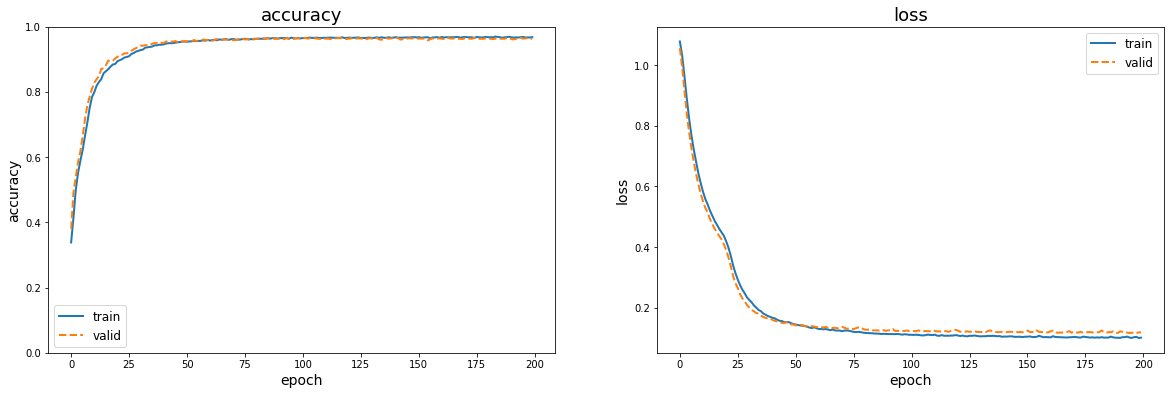

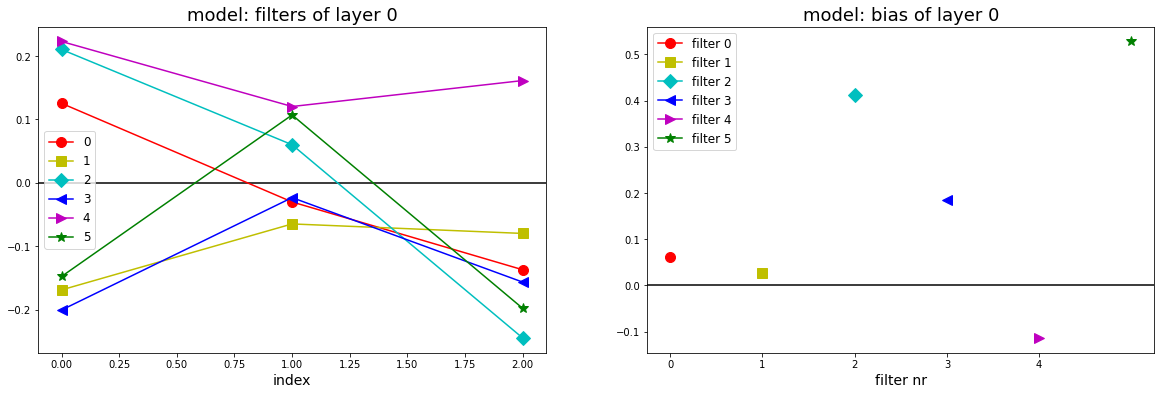

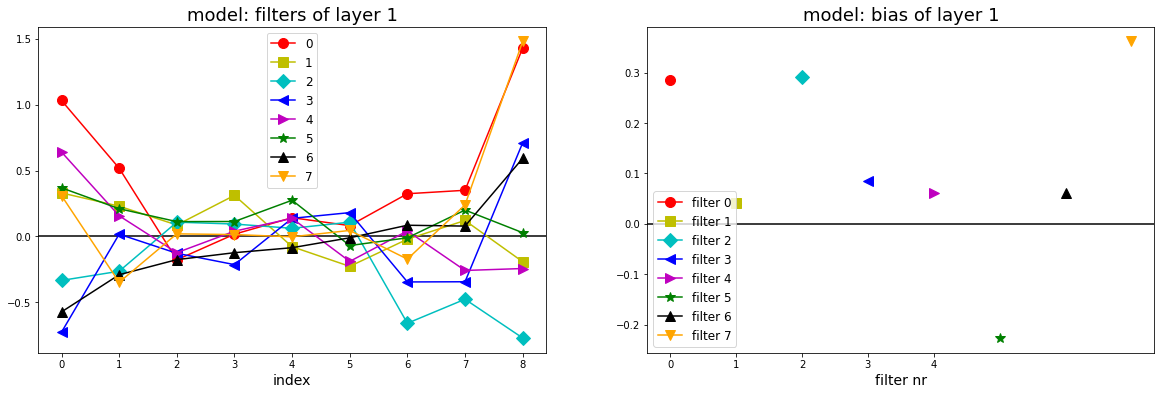

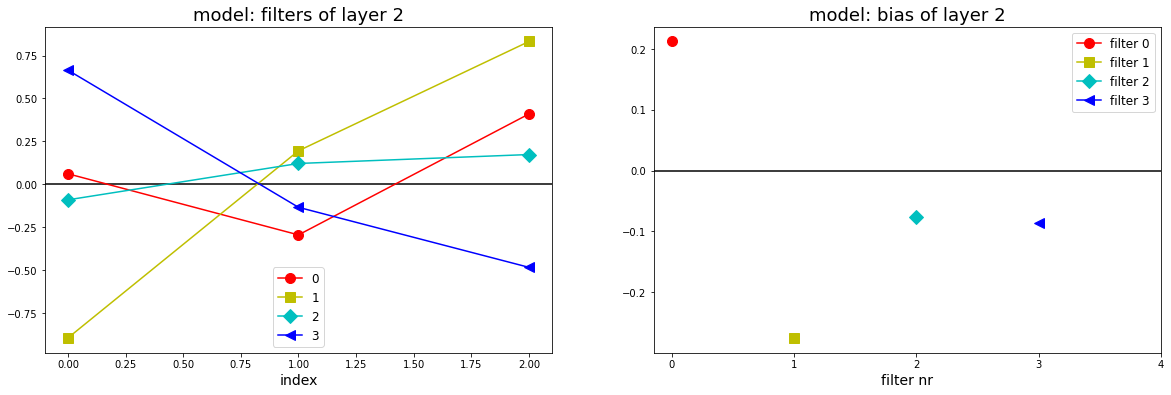

In [ ]:
fig = plt.figure(figsize=(20,6))
ax = plot_utils.plot_history(fit, fig)
plt.show()

fig1 = plt.figure(figsize=(20,6))
plot_utils.plot_weights(model, 0, fig=fig1)
plt.show()
fig2 = plt.figure(figsize=(20,6))
plot_utils.plot_weights(model, 1, fig=fig2)
plt.show()
fig1 = plt.figure(figsize=(20,6))
plot_utils.plot_weights(model, 2, fig=fig1)
plt.show()

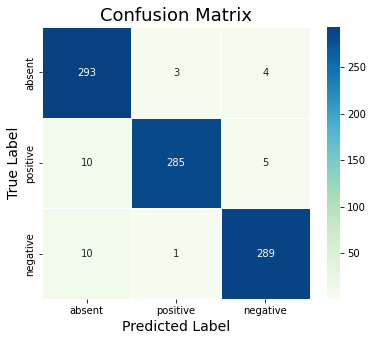

In [ ]:
y_pred_test = model.predict(x_test)
# Take the class with the highest probability from the val predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

fig = plt.figure(figsize=(6,5))
ax = plot_utils.show_confusion_matrix(true=max_y_test, pred=max_y_pred_test, fig=fig)
plt.show()

_Is it working better?_

->This model performs slightly better than the ones previously tested.

_If yes, which could be the reason?_

->We think the better performance can be adressed to the use of GlobalMaxPooling over AveragePooling, 


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=452e6836-b7b8-455e-80d9-d4109b6baddf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>